<a href="https://colab.research.google.com/github/open-mmlab/mmaction2/blob/master/demo/mmaction2_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Dependencies

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:
# Install some optional requirements
# !pip install -r requirements/optional.txt

In [1]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMAction2 installation
import mmaction
print(mmaction.__version__)

# Check MMCV installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

import sys
sys.path.append('/home/actrec/.local/lib/python3.6/site-packages/decord-0.5.3-py3.6-linux-x86_64.egg')
import decord
import pickle

1.7.0+cu110 True
0.12.0
11.0
GCC 7.5


In [4]:
cd ..

/home/actrec/.virtualenvs/mmaction/mmaction2


In [1]:
ls

checkpoints/  demo/        LICENSE              README.md         setup.cfg
childact-mm/  docker/      mmaction/            README_zh-CN.md   setup.py
configs/      docs/        mmaction2.egg-info/  requirements/     tests/
data/         docs_zh_CN/  my-mmaction.ipynb    requirements.txt  tools/


# TSN 94.44% 

In [25]:
# !mkdir checkpoints
# !wget -c https://download.openmmlab.com/   .pth \
#       -O checkpoints/db3c461.pth

--2021-03-22 01:46:07--  https://download.openmmlab.com/mmaction/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics600_rgb/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99220779 (95M) [application/octet-stream]
Saving to: ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’

checkpoints/tsn_r50 100%[===================>]  94,62M  10,5MB/s    in 11s     

2021-03-22 01:46:22 (8,61 MB/s) - ‘checkpoints/tsn_r50_video_1x1x8_100e_kinetics600_rgb_20201015-4db3c461.pth’ saved [99220779/99220779]



In [6]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsn/tsn_r50_video_1x1x8_100e_kinetics400_rgb.py')

In [7]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './childact-checkpoints/childact-tsn/epoch_30.pth'
cfg.resume_from = './childact-checkpoints/childact-tsn/epoch_30.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-tsn-2/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 32
cfg.optimizer.lr = 0.0001
# cfg.lr_config.type = 'cyclic'
cfg.total_epochs = 40

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 20
cfg.evaluation.interval = 2
# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNet',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False),
    cls_head=dict(
        type='TSNHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.4,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(type='SGD', lr=0.0001, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 0.0001),
    cyclic_times=1,
    step_ratio_up=0.4)
total_epochs = 40
checkpoint_config = dict(interval=2)
log_config = dict(interval=20, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './childact-checkpoints/childact-tsn/epoch_30.pth'
resume_from = './childact-checkpoints/childact

In [8]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 14:12:39,300 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias'}


Use load_from_torchvision loader


2021-03-25 14:12:39,359 - mmaction - INFO - load checkpoint from ./childact-checkpoints/childact-tsn/epoch_30.pth
2021-03-25 14:12:39,360 - mmaction - INFO - Use load_from_local loader
2021-03-25 14:12:39,874 - mmaction - INFO - resumed epoch 30, iter 1155
2021-03-25 14:12:39,875 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-tsn-2
2021-03-25 14:12:39,876 - mmaction - INFO - workflow: [('train', 1)], max: 40 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning: runner.meta is None. Creating a empty one.
  warnings.warn('runner.meta is None. Creating a empty one.')
2021-03-25 14:15:28,124 - mmaction - INFO - Epoch [31][20/33]	lr: 4.077e-04, eta: 0:20:19, time: 8.412, data_time: 7.526, memory: 21540, top1_acc: 0.9422, top5_acc: 1.0000, loss_cls: 0.1803, loss: 0.1803, grad_norm: 3.5818
2021-03-25 14:20:14,028 - mmaction -

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-25 14:22:39,733 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:22:39,735 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-25 14:22:39,736 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:22:39,738 - mmaction - INFO - 
mean_acc	0.8571
2021-03-25 14:22:40,001 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_32.pth.
2021-03-25 14:22:40,002 - mmaction - INFO - Best top1_acc is 0.8571 at 32 epoch.
2021-03-25 14:22:40,003 - mmaction - INFO - Epoch(val) [32][33]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-25 14:25:26,258 - mmaction - INFO - Epoch [33][20/33]	lr: 1.249e-04, eta: 0:07:44, time: 8.313, data_time: 7.438, memory: 21540, top1_acc: 0.9141, top5_acc: 1.0000, loss_cls: 0.2269, loss: 0.2269, grad_norm: 4.7388
2021-03-25 14:30:13,231 - mmaction - INFO - Epoch [34][20/33]	lr: 4.337e-05, eta: 0:04:21, time: 8.550, data_time: 7.676, memory: 21540, top1_acc: 0.9359, top5_acc: 0.9984, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-25 14:32:36,374 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:32:36,376 - mmaction - INFO - 
top1_acc	0.8651
top5_acc	1.0000
2021-03-25 14:32:36,376 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:32:36,378 - mmaction - INFO - 
mean_acc	0.8651
2021-03-25 14:32:36,670 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_34.pth.
2021-03-25 14:32:36,671 - mmaction - INFO - Best top1_acc is 0.8651 at 34 epoch.
2021-03-25 14:32:36,672 - mmaction - INFO - Epoch(val) [34][33]	top1_acc: 0.8651, top5_acc: 1.0000, mean_class_accuracy: 0.8651
2021-03-25 14:35:22,905 - mmaction - INFO - Epoch [35][20/33]	lr: 3.904e-06, eta: 0:01:12, time: 8.312, data_time: 7.438, memory: 21540, top1_acc: 0.8984, top5_acc: 0.9984, loss_cls: 0.2482, loss: 0.2482, grad_norm: 4.5644
2021-03-25 14:40:10,661 - mmaction - INFO - Epoch [36][20/33]	lr: 5.144e-04, eta: -1 day, 23:58:11, time: 8.546, data_time: 7.670, memory: 21540, top1_acc: 0.9000, top5_acc:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.6 task/s, elapsed: 35s, ETA:     0s

2021-03-25 14:42:33,137 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:42:33,139 - mmaction - INFO - 
top1_acc	0.8810
top5_acc	1.0000
2021-03-25 14:42:33,139 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:42:33,141 - mmaction - INFO - 
mean_acc	0.8810
2021-03-25 14:42:33,430 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_36.pth.
2021-03-25 14:42:33,431 - mmaction - INFO - Best top1_acc is 0.8810 at 36 epoch.
2021-03-25 14:42:33,431 - mmaction - INFO - Epoch(val) [36][33]	top1_acc: 0.8810, top5_acc: 1.0000, mean_class_accuracy: 0.8810
2021-03-25 14:45:18,239 - mmaction - INFO - Epoch [37][20/33]	lr: 6.068e-04, eta: -1 day, 23:55:14, time: 8.240, data_time: 7.367, memory: 21540, top1_acc: 0.9187, top5_acc: 1.0000, loss_cls: 0.2261, loss: 0.2261, grad_norm: 4.7761
2021-03-25 14:50:03,231 - mmaction - INFO - Epoch [38][20/33]	lr: 7.817e-04, eta: -1 day, 23:52:19, time: 8.473, data_time: 7.601, memory: 21540, top1_acc: 0.9125, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.6 task/s, elapsed: 35s, ETA:     0s

2021-03-25 14:52:34,766 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 14:52:34,767 - mmaction - INFO - 
top1_acc	0.8810
top5_acc	1.0000
2021-03-25 14:52:34,768 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 14:52:34,769 - mmaction - INFO - 
mean_acc	0.8810
2021-03-25 14:52:34,770 - mmaction - INFO - Epoch(val) [38][33]	top1_acc: 0.8810, top5_acc: 1.0000, mean_class_accuracy: 0.8810
2021-03-25 14:55:23,918 - mmaction - INFO - Epoch [39][20/33]	lr: 1.032e-03, eta: -1 day, 23:49:25, time: 8.457, data_time: 7.586, memory: 21540, top1_acc: 0.9187, top5_acc: 1.0000, loss_cls: 0.2099, loss: 0.2099, grad_norm: 5.1517
2021-03-25 15:00:04,888 - mmaction - INFO - Epoch [40][20/33]	lr: 1.349e-03, eta: -1 day, 23:46:33, time: 8.332, data_time: 7.458, memory: 21540, top1_acc: 0.9000, top5_acc: 1.0000, loss_cls: 0.2583, loss: 0.2583, grad_norm: 4.9323
2021-03-25 15:02:03,446 - mmaction - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 3.5 task/s, elapsed: 36s, ETA:     0s

2021-03-25 15:02:39,524 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:02:39,526 - mmaction - INFO - 
top1_acc	0.8810
top5_acc	1.0000
2021-03-25 15:02:39,526 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:02:39,527 - mmaction - INFO - 
mean_acc	0.8810
2021-03-25 15:02:39,528 - mmaction - INFO - Epoch(val) [40][33]	top1_acc: 0.8810, top5_acc: 1.0000, mean_class_accuracy: 0.8810


In [9]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [10]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel

# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=16,
        workers_per_gpu=cfg.data.workers_per_gpu,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.2 task/s, elapsed: 56s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9444
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9444
top1_acc: 0.9444
top5_acc: 1.0000
mean_class_accuracy: 0.9444


<AxesSubplot:>

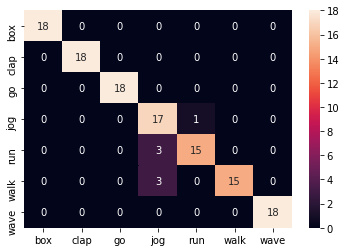

In [11]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# SlowFast 91.27%

In [2]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth \
      -O checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth

--2021-03-22 18:16:35--  https://download.openmmlab.com/mmaction/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138274276 (132M) [application/octet-stream]
Saving to: ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’

checkpoints/slowfas 100%[===================>] 131,87M  6,72MB/s    in 17s     

2021-03-22 18:16:55 (7,79 MB/s) - ‘checkpoints/slowfast_r50_video_4x16x1_256e_kinetics400_rgb_20200826-f85b90c5.pth’ saved [138274276/138274276]



In [7]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/slowfast/slowfast_r50_video_4x16x1_256e_kinetics400_rgb.py')

In [8]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './childact-checkpoints/childact-slowfast3/best_top1_acc_epoch_5.pth'
cfg.resume_from = './childact-checkpoints/childact-slowfast3/best_top1_acc_epoch_5.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-slowfast4/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 16
# cfg.data.workers_per_gpu = 4
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
cfg.optimizer.lr = 0.001

# cfg.lr_config = dict(
#     policy='cyclic',
#     target_ratio=(10, 1e-4),
#     cyclic_times=1,
#     step_ratio_up=0.4,
# )
cfg.total_epochs = 11
cfg.evaluation.interval = 1
# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 2
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 40

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)
cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowFast',
        pretrained=None,
        resample_rate=8,
        speed_ratio=8,
        channel_ratio=8,
        slow_pathway=dict(
            type='resnet3d',
            depth=50,
            pretrained=None,
            lateral=True,
            conv1_kernel=(1, 7, 7),
            dilations=(1, 1, 1, 1),
            conv1_stride_t=1,
            pool1_stride_t=1,
            inflate=(0, 0, 1, 1),
            norm_eval=False),
        fast_pathway=dict(
            type='resnet3d',
            depth=50,
            pretrained=None,
            lateral=False,
            base_channels=8,
            conv1_kernel=(5, 7, 7),
            conv1_stride_t=1,
            pool1_stride_t=1,
            norm_eval=False)),
    cls_head=dict(
        type='SlowFastHead',
        in_channels=2304,
        num_classes=7,
        spatial_type='avg',
        dropout_ratio=0.5),
    train_cfg=None,
    test_cf

In [9]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 12:40:03,663 - mmaction - INFO - load checkpoint from ./childact-checkpoints/childact-slowfast3/best_top1_acc_epoch_5.pth
2021-03-25 12:40:03,664 - mmaction - INFO - Use load_from_local loader
2021-03-25 12:40:03,874 - mmaction - INFO - resumed epoch 5, iter 330
2021-03-25 12:40:03,876 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-slowfast4
2021-03-25 12:40:03,877 - mmaction - INFO - workflow: [('train', 1)], max: 11 epochs
2021-03-25 12:41:36,333 - mmaction - INFO - Epoch [6][40/66]	lr: 1.416e-02, eta: 0:13:42, time: 2.311, data_time: 1.426, memory: 12207, top1_acc: 0.7500, top5_acc: 0.9844, loss_cls: 0.6193, loss: 0.6193, grad_norm: 0.9436
2021-03-25 12:42:28,631 - mmaction - INFO - Saving checkpoint at 6 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:42:48,742 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:42:48,743 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-25 12:42:48,744 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:42:48,744 - mmaction - INFO - 
mean_acc	0.8254
2021-03-25 12:42:49,135 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_6.pth.
2021-03-25 12:42:49,136 - mmaction - INFO - Best top1_acc is 0.8254 at 6 epoch.
2021-03-25 12:42:49,137 - mmaction - INFO - Epoch(val) [6][66]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-25 12:44:22,536 - mmaction - INFO - Epoch [7][40/66]	lr: 1.177e-02, eta: 0:08:28, time: 2.335, data_time: 1.443, memory: 12207, top1_acc: 0.6984, top5_acc: 0.9906, loss_cls: 0.7002, loss: 0.7002, grad_norm: 1.1397


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:45:38,793 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:45:38,795 - mmaction - INFO - 
top1_acc	0.7937
top5_acc	1.0000
2021-03-25 12:45:38,796 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:45:38,797 - mmaction - INFO - 
mean_acc	0.7937
2021-03-25 12:45:38,798 - mmaction - INFO - Epoch(val) [7][66]	top1_acc: 0.7937, top5_acc: 1.0000, mean_class_accuracy: 0.7937
2021-03-25 12:47:09,756 - mmaction - INFO - Epoch [8][40/66]	lr: 8.796e-03, eta: 0:06:00, time: 2.274, data_time: 1.378, memory: 12207, top1_acc: 0.7109, top5_acc: 0.9891, loss_cls: 0.7145, loss: 0.7145, grad_norm: 1.0675
2021-03-25 12:48:02,808 - mmaction - INFO - Saving checkpoint at 8 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.5 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:48:22,782 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:48:22,783 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-25 12:48:22,784 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:48:22,784 - mmaction - INFO - 
mean_acc	0.8492
2021-03-25 12:48:23,196 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_8.pth.
2021-03-25 12:48:23,197 - mmaction - INFO - Best top1_acc is 0.8492 at 8 epoch.
2021-03-25 12:48:23,198 - mmaction - INFO - Epoch(val) [8][66]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-25 12:49:56,477 - mmaction - INFO - Epoch [9][40/66]	lr: 5.650e-03, eta: 0:04:05, time: 2.332, data_time: 1.436, memory: 12207, top1_acc: 0.7219, top5_acc: 0.9875, loss_cls: 0.7207, loss: 0.7207, grad_norm: 1.1247


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:51:07,151 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:51:07,154 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-25 12:51:07,155 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:51:07,157 - mmaction - INFO - 
mean_acc	0.8254
2021-03-25 12:51:07,158 - mmaction - INFO - Epoch(val) [9][66]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-25 12:52:37,352 - mmaction - INFO - Epoch [10][40/66]	lr: 2.809e-03, eta: 0:02:19, time: 2.255, data_time: 1.360, memory: 12207, top1_acc: 0.7141, top5_acc: 0.9922, loss_cls: 0.6923, loss: 0.6923, grad_norm: 1.0608
2021-03-25 12:53:32,091 - mmaction - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.5 task/s, elapsed: 19s, ETA:     0s

2021-03-25 12:53:52,057 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:53:52,059 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-25 12:53:52,059 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:53:52,061 - mmaction - INFO - 
mean_acc	0.8492
2021-03-25 12:53:52,062 - mmaction - INFO - Epoch(val) [10][66]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-25 12:55:24,466 - mmaction - INFO - Epoch [11][40/66]	lr: 7.703e-04, eta: 0:00:38, time: 2.310, data_time: 1.412, memory: 12207, top1_acc: 0.6969, top5_acc: 0.9859, loss_cls: 0.7326, loss: 0.7326, grad_norm: 1.0574


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.4 task/s, elapsed: 20s, ETA:     0s

2021-03-25 12:56:38,924 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 12:56:38,926 - mmaction - INFO - 
top1_acc	0.8333
top5_acc	1.0000
2021-03-25 12:56:38,926 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 12:56:38,928 - mmaction - INFO - 
mean_acc	0.8333
2021-03-25 12:56:38,928 - mmaction - INFO - Epoch(val) [11][66]	top1_acc: 0.8333, top5_acc: 1.0000, mean_class_accuracy: 0.8333


In [5]:
torch.cuda.ipc_collect()
torch.cuda.empty_cache()
import gc
# gc.enable()
gc.collect()

0

In [10]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [11]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# checkpoint = './childact-checkpoints/childact-slowfast/best_top1_acc_epoch_50.pth'
# modelt = init_recognizer(cfg, checkpoint, device='cuda:0')
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=2,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.0 task/s, elapsed: 2773s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

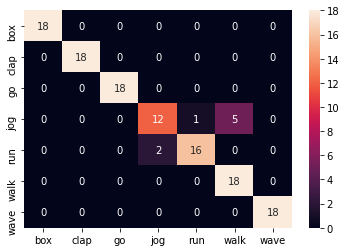

In [12]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# R(2+1)D 59.52%

In [6]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth \
      -O checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth

--2021-03-24 13:44:27--  https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.252.96.35
Connecting to download.openmmlab.com (download.openmmlab.com)|47.252.96.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255320099 (243M) [application/octet-stream]
Saving to: ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’

checkpoints/r2plus1 100%[===================>] 243,49M  6,98MB/s    in 32s     

2021-03-24 13:45:05 (7,72 MB/s) - ‘checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth’ saved [255320099/255320099]



In [17]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/r2plus1d/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb.py')

In [18]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = './checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth'
# cfg.resume_from = './childact-checkpoints/childact-r2plus1d/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-r2plus1d-3'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 32
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 10

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
del cfg.model.backbone['norm_cfg']
# cfg.model.cls_head.type = "TSNHead"
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet2Plus1d',
        depth=34,
        pretrained=None,
        pretrained2d=False,
        norm_eval=False,
        conv_cfg=dict(type='Conv2plus1d'),
        conv1_kernel=(3, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(1, 1, 1, 1),
        spatial_strides=(1, 2, 2, 2),
        temporal_strides=(1, 2, 2, 2),
        zero_init_residual=False,
        act_cfg=dict(type='ReLU')),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=512,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=4)
log_config = dict(interval=10, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = './checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth'
resume_from = None

In [ ]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-25 15:30:20,791 - mmaction - INFO - load checkpoint from ./checkpoints/r2plus1d_r34_video_8x8x1_180e_kinetics400_rgb_20200826-ab35a529.pth
2021-03-25 15:30:20,792 - mmaction - INFO - Use load_from_local loader
2021-03-25 15:30:20,949 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 512]) from checkpoint, the shape in current model is torch.Size([7, 512]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-25 15:30:20,956 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-r2plus1d-3
2021-03-25 15:30:20,956 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 15:39:57,043 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:39:57,045 - mmaction - INFO - 
top1_acc	0.3651
top5_acc	1.0000
2021-03-25 15:39:57,046 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:39:57,047 - mmaction - INFO - 
mean_acc	0.3651
2021-03-25 15:39:57,852 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-25 15:39:57,854 - mmaction - INFO - Best top1_acc is 0.3651 at 5 epoch.
2021-03-25 15:39:57,855 - mmaction - INFO - Epoch(val) [5][33]	top1_acc: 0.3651, top5_acc: 1.0000, mean_class_accuracy: 0.3651
2021-03-25 15:40:40,465 - mmaction - INFO - Epoch [6][10/33]	lr: 4.809e-01, eta: 1:21:13, time: 4.260, data_time: 2.969, memory: 21540, top1_acc: 0.3094, top5_acc: 0.9656, loss_cls: 1.5239, loss: 1.5239, grad_norm: 0.5280
2021-03-25 15:41:09,933 - mmaction - INFO - Epoch [6][20/33]	lr: 5.121e-01, eta: 1:20:17, time: 2.947, data_time: 1.667, memory: 21540, top1_acc: 0.3312, top5_acc: 0.9750, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 15:49:29,166 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:49:29,167 - mmaction - INFO - 
top1_acc	0.3175
top5_acc	0.9762
2021-03-25 15:49:29,168 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:49:29,168 - mmaction - INFO - 
mean_acc	0.3175
2021-03-25 15:49:29,169 - mmaction - INFO - Epoch(val) [10][33]	top1_acc: 0.3175, top5_acc: 0.9762, mean_class_accuracy: 0.3175
2021-03-25 15:50:15,748 - mmaction - INFO - Epoch [11][10/33]	lr: 1.111e+00, eta: 1:11:55, time: 4.658, data_time: 3.382, memory: 21540, top1_acc: 0.3438, top5_acc: 0.9625, loss_cls: 1.5662, loss: 1.5662, grad_norm: 0.5038
2021-03-25 15:50:44,778 - mmaction - INFO - Epoch [11][20/33]	lr: 1.152e+00, eta: 1:11:11, time: 2.903, data_time: 1.629, memory: 21540, top1_acc: 0.3219, top5_acc: 0.9563, loss_cls: 1.5483, loss: 1.5483, grad_norm: 0.5952
2021-03-25 15:51:14,411 - mmaction - INFO - Epoch [11][30/33]	lr: 1.194e+00, eta: 1:10:31, time: 2.963, data_time: 1.683, memory: 21540

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 15:58:57,064 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 15:58:57,066 - mmaction - INFO - 
top1_acc	0.1984
top5_acc	0.7460
2021-03-25 15:58:57,066 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 15:58:57,067 - mmaction - INFO - 
mean_acc	0.1984
2021-03-25 15:58:57,068 - mmaction - INFO - Epoch(val) [15][33]	top1_acc: 0.1984, top5_acc: 0.7460, mean_class_accuracy: 0.1984
2021-03-25 15:59:40,086 - mmaction - INFO - Epoch [16][10/33]	lr: 1.734e+00, eta: 1:02:45, time: 4.301, data_time: 3.018, memory: 21540, top1_acc: 0.2938, top5_acc: 0.9437, loss_cls: 1.6775, loss: 1.6775, grad_norm: 0.4904
2021-03-25 16:00:07,571 - mmaction - INFO - Epoch [16][20/33]	lr: 1.763e+00, eta: 1:02:02, time: 2.748, data_time: 1.469, memory: 21540, top1_acc: 0.3063, top5_acc: 0.9719, loss_cls: 1.6790, loss: 1.6790, grad_norm: 0.4985
2021-03-25 16:00:40,896 - mmaction - INFO - Epoch [16][30/33]	lr: 1.791e+00, eta: 1:01:34, time: 3.332, data_time: 2.050, memory: 21540

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-25 16:08:26,069 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 16:08:26,070 - mmaction - INFO - 
top1_acc	0.2381
top5_acc	1.0000
2021-03-25 16:08:26,071 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 16:08:26,072 - mmaction - INFO - 
mean_acc	0.2381
2021-03-25 16:08:26,073 - mmaction - INFO - Epoch(val) [20][33]	top1_acc: 0.2381, top5_acc: 1.0000, mean_class_accuracy: 0.2381
2021-03-25 16:09:08,179 - mmaction - INFO - Epoch [21][10/33]	lr: 2.000e+00, eta: 0:53:45, time: 4.210, data_time: 2.933, memory: 21540, top1_acc: 0.2875, top5_acc: 0.9437, loss_cls: 1.7203, loss: 1.7203, grad_norm: 0.4388
2021-03-25 16:09:35,054 - mmaction - INFO - Epoch [21][20/33]	lr: 2.000e+00, eta: 0:53:06, time: 2.687, data_time: 1.415, memory: 21540, top1_acc: 0.3156, top5_acc: 0.9187, loss_cls: 1.6964, loss: 1.6964, grad_norm: 0.4517
2021-03-25 16:10:09,760 - mmaction - INFO - Epoch [21][30/33]	lr: 1.999e+00, eta: 0:52:38, time: 3.471, data_time: 2.192, memory: 21540

In [30]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [34]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader, load_annotations, build_dataset
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.7 task/s, elapsed: 180s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.5952
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.5952
top1_acc: 0.5952
top5_acc: 1.0000
mean_class_accuracy: 0.5952


<AxesSubplot:>

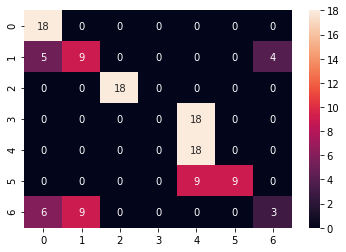

In [73]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True)

# TSM 93.65%

In [3]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth \
      -O checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth

--2021-03-24 19:15:04--  https://download.openmmlab.com/mmaction/recognition/tsm/tsm_r50_video_1x1x8_100e_kinetics400_rgb/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97579687 (93M) [application/octet-stream]
Saving to: ‘checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth’

checkpoints/tsm_r50 100%[===================>]  93,06M  8,72MB/s    in 12s     

2021-03-24 19:15:20 (7,71 MB/s) - ‘checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth’ saved [97579687/97579687]



In [9]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tsm/tsm_r50_video_1x1x8_50e_kinetics400_rgb.py')

In [10]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_split/train/'
cfg.data_root_val = 'data/childact_split/val/'
cfg.ann_file_train = 'data/childact_split/childact_train_video.txt'
cfg.ann_file_val = 'data/childact_split/childact_val_video.txt'
cfg.ann_file_test = 'data/childact_split/childact_test_video.txt'

cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_split/childact_test_video.txt'
cfg.data.test.data_prefix = 'data/childact_split/test/'

cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_split/childact_train_video.txt'
cfg.data.train.data_prefix = 'data/childact_split/train/'

cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_split/childact_val_video.txt'
cfg.data.val.data_prefix = 'data/childact_split/val/'

# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-tsm'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-4),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 4
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 25

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')


Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNetTSM',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False,
        shift_div=8),
    cls_head=dict(
        type='TSMHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.5,
        init_std=0.001,
        is_shift=True),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
optimizer = dict(
    type='SGD',
    constructor='TSMOptimizerConstructor',
    paramwise_cfg=dict(fc_lr5=True),
    lr=0.02,
    weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=20, norm_type=2))
lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 0.0001),
    cyclic_times=1,
    step_ratio_up=0.4)
total_epochs = 51
checkpoint_config = dict(interval=4)
log_config = dict(interval=25, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
l

In [11]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-24 21:03:31,550 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias'}


Use load_from_torchvision loader


2021-03-24 21:03:33,980 - mmaction - INFO - load checkpoint from checkpoints/tsm_r50_video_1x1x8_100e_kinetics400_rgb_20200702-a77f4328.pth
2021-03-24 21:03:33,982 - mmaction - INFO - Use load_from_local loader
2021-03-24 21:03:34,081 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-24 21:03:34,086 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-tsm
2021-03-24 21:03:34,087 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
/home/actrec/.virtualenvs/mmaction/mmaction2/mmaction/core/evaluation/eval_hooks.py:131: UserWarning:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 21:26:56,186 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 21:26:56,188 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-24 21:26:56,188 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 21:26:56,190 - mmaction - INFO - 
mean_acc	0.8016
2021-03-24 21:26:56,341 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-24 21:26:56,342 - mmaction - INFO - Best top1_acc is 0.8016 at 5 epoch.
2021-03-24 21:26:56,343 - mmaction - INFO - Epoch(val) [5][44]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-24 21:29:50,484 - mmaction - INFO - Epoch [6][25/44]	lr: 5.091e-02, eta: 2:18:31, time: 6.965, data_time: 5.991, memory: 20204, top1_acc: 0.8633, top5_acc: 0.9983, loss_cls: 0.3578, loss: 0.3578, grad_norm: 4.3697
2021-03-24 21:34:28,680 - mmaction - INFO - Epoch [7][25/44]	lr: 6.203e-02, eta: 2:15:02, time: 7.168, data_time: 6.192, memory: 20204, top1_acc: 0.8700, top5_acc: 0.9983, loss_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 21:50:22,735 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 21:50:22,737 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-03-24 21:50:22,737 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 21:50:22,739 - mmaction - INFO - 
mean_acc	0.8492
2021-03-24 21:50:22,912 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-24 21:50:22,912 - mmaction - INFO - Best top1_acc is 0.8492 at 10 epoch.
2021-03-24 21:50:22,913 - mmaction - INFO - Epoch(val) [10][44]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-03-24 21:53:16,024 - mmaction - INFO - Epoch [11][25/44]	lr: 1.149e-01, eta: 1:59:43, time: 6.924, data_time: 5.948, memory: 20204, top1_acc: 0.8817, top5_acc: 1.0000, loss_cls: 0.3227, loss: 0.3227, grad_norm: 2.9154
2021-03-24 21:57:42,847 - mmaction - INFO - Epoch [12][25/44]	lr: 1.286e-01, eta: 1:56:20, time: 6.806, data_time: 5.830, memory: 20204, top1_acc: 0.8550, top5_acc: 0.9983, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 22:13:51,448 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 22:13:51,450 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 22:13:51,451 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 22:13:51,452 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 22:13:51,453 - mmaction - INFO - Epoch(val) [15][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 22:16:43,943 - mmaction - INFO - Epoch [16][25/44]	lr: 1.761e-01, eta: 1:43:45, time: 6.899, data_time: 5.905, memory: 20204, top1_acc: 0.8417, top5_acc: 1.0000, loss_cls: 0.3540, loss: 0.3540, grad_norm: 2.6687
2021-03-24 22:18:21,773 - mmaction - INFO - Saving checkpoint at 16 epochs
2021-03-24 22:21:12,732 - mmaction - INFO - Epoch [17][25/44]	lr: 1.847e-01, eta: 1:40:39, time: 6.831, data_time: 5.806, memory: 20204, top1_acc: 0.8600, top5_acc: 1.0000, loss_cls: 0.3870, loss: 0.3870, grad_norm: 3.2032
2021-03-24 22:25:49,296 - mmaction - INFO - Epoch [18][25/44

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 22:37:17,321 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 22:37:17,323 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 22:37:17,323 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 22:37:17,325 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 22:37:17,326 - mmaction - INFO - Epoch(val) [20][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 22:40:03,624 - mmaction - INFO - Epoch [21][25/44]	lr: 2.000e-01, eta: 1:28:33, time: 6.652, data_time: 5.674, memory: 20204, top1_acc: 0.8833, top5_acc: 1.0000, loss_cls: 0.2851, loss: 0.2851, grad_norm: 1.9111
2021-03-24 22:44:38,747 - mmaction - INFO - Epoch [22][25/44]	lr: 1.993e-01, eta: 1:25:35, time: 6.870, data_time: 5.893, memory: 20204, top1_acc: 0.8867, top5_acc: 1.0000, loss_cls: 0.2601, loss: 0.2601, grad_norm: 2.1638
2021-03-24 22:49:22,392 - mmaction - INFO - Epoch [23][25/44]	lr: 1.976e-01, eta: 1:22:50, time: 7.289, data_time: 6.287, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-24 23:00:59,644 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:00:59,647 - mmaction - INFO - 
top1_acc	0.8175
top5_acc	1.0000
2021-03-24 23:00:59,648 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:00:59,651 - mmaction - INFO - 
mean_acc	0.8175
2021-03-24 23:00:59,652 - mmaction - INFO - Epoch(val) [25][44]	top1_acc: 0.8175, top5_acc: 1.0000, mean_class_accuracy: 0.8175
2021-03-24 23:03:51,401 - mmaction - INFO - Epoch [26][25/44]	lr: 1.863e-01, eta: 1:14:06, time: 6.870, data_time: 5.887, memory: 20204, top1_acc: 0.8933, top5_acc: 1.0000, loss_cls: 0.2764, loss: 0.2764, grad_norm: 2.1380
2021-03-24 23:08:27,656 - mmaction - INFO - Epoch [27][25/44]	lr: 1.807e-01, eta: 1:11:07, time: 6.820, data_time: 5.837, memory: 20204, top1_acc: 0.8933, top5_acc: 0.9983, loss_cls: 0.2690, loss: 0.2690, grad_norm: 2.0275
2021-03-24 23:12:53,090 - mmaction - INFO - Epoch [28][25/44]	lr: 1.742e-01, eta: 1:08:04, time: 6.593, data_time: 5.600, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-24 23:24:46,975 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:24:46,977 - mmaction - INFO - 
top1_acc	0.8730
top5_acc	1.0000
2021-03-24 23:24:46,977 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:24:46,979 - mmaction - INFO - 
mean_acc	0.8730
2021-03-24 23:24:47,130 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-03-24 23:24:47,131 - mmaction - INFO - Best top1_acc is 0.8730 at 30 epoch.
2021-03-24 23:24:47,132 - mmaction - INFO - Epoch(val) [30][44]	top1_acc: 0.8730, top5_acc: 1.0000, mean_class_accuracy: 0.8730
2021-03-24 23:27:36,817 - mmaction - INFO - Epoch [31][25/44]	lr: 1.504e-01, eta: 0:59:15, time: 6.787, data_time: 5.808, memory: 20204, top1_acc: 0.9150, top5_acc: 0.9983, loss_cls: 0.2196, loss: 0.2196, grad_norm: 1.8701
2021-03-24 23:32:14,860 - mmaction - INFO - Epoch [32][25/44]	lr: 1.413e-01, eta: 0:56:22, time: 7.025, data_time: 6.044, memory: 20204, top1_acc: 0.9217, top5_acc: 1.0000, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-24 23:48:22,662 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-24 23:48:22,664 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	1.0000
2021-03-24 23:48:22,665 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-24 23:48:22,667 - mmaction - INFO - 
mean_acc	0.8254
2021-03-24 23:48:22,668 - mmaction - INFO - Epoch(val) [35][44]	top1_acc: 0.8254, top5_acc: 1.0000, mean_class_accuracy: 0.8254
2021-03-24 23:51:14,376 - mmaction - INFO - Epoch [36][25/44]	lr: 1.015e-01, eta: 0:44:36, time: 6.868, data_time: 5.877, memory: 20204, top1_acc: 0.9167, top5_acc: 1.0000, loss_cls: 0.1841, loss: 0.1841, grad_norm: 2.0693
2021-03-24 23:52:51,813 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-03-24 23:55:40,270 - mmaction - INFO - Epoch [37][25/44]	lr: 9.127e-02, eta: 0:41:41, time: 6.732, data_time: 5.754, memory: 20204, top1_acc: 0.9533, top5_acc: 1.0000, loss_cls: 0.1247, loss: 0.1247, grad_norm: 1.3474
2021-03-25 00:00:14,754 - mmaction - INFO - Epoch [38][25/44

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 48s, ETA:     0s

2021-03-25 00:11:59,894 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 00:11:59,896 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-03-25 00:11:59,897 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 00:11:59,898 - mmaction - INFO - 
mean_acc	0.9206
2021-03-25 00:12:00,066 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-25 00:12:00,067 - mmaction - INFO - Best top1_acc is 0.9206 at 40 epoch.
2021-03-25 00:12:00,068 - mmaction - INFO - Epoch(val) [40][44]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-03-25 00:15:02,371 - mmaction - INFO - Epoch [41][25/44]	lr: 5.224e-02, eta: 0:30:08, time: 7.292, data_time: 6.300, memory: 20204, top1_acc: 0.9417, top5_acc: 1.0000, loss_cls: 0.1471, loss: 0.1471, grad_norm: 1.4060
2021-03-25 00:19:40,726 - mmaction - INFO - Epoch [42][25/44]	lr: 4.349e-02, eta: 0:27:16, time: 7.081, data_time: 6.099, memory: 20204, top1_acc: 0.9417, top5_acc: 0.9983, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.6 task/s, elapsed: 49s, ETA:     0s

2021-03-25 00:39:22,798 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 00:39:22,800 - mmaction - INFO - 
top1_acc	0.9048
top5_acc	1.0000
2021-03-25 00:39:22,800 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 00:39:22,802 - mmaction - INFO - 
mean_acc	0.9048
2021-03-25 00:39:22,803 - mmaction - INFO - Epoch(val) [45][44]	top1_acc: 0.9048, top5_acc: 1.0000, mean_class_accuracy: 0.9048
2021-03-25 00:42:20,754 - mmaction - INFO - Epoch [46][25/44]	lr: 1.526e-02, eta: 0:15:56, time: 7.118, data_time: 6.136, memory: 20204, top1_acc: 0.9550, top5_acc: 1.0000, loss_cls: 0.1165, loss: 0.1165, grad_norm: 1.5267
2021-03-25 00:46:57,192 - mmaction - INFO - Epoch [47][25/44]	lr: 1.027e-02, eta: 0:12:59, time: 7.019, data_time: 6.046, memory: 20204, top1_acc: 0.9633, top5_acc: 1.0000, loss_cls: 0.0944, loss: 0.0944, grad_norm: 1.2650
2021-03-25 00:51:21,230 - mmaction - INFO - Epoch [48][25/44]	lr: 6.220e-03, eta: 0:10:03, time: 6.794, data_time: 5.818, memory: 20204

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.3 task/s, elapsed: 98s, ETA:     0s

2021-03-25 01:03:51,321 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-25 01:03:51,323 - mmaction - INFO - 
top1_acc	0.9127
top5_acc	1.0000
2021-03-25 01:03:51,324 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-25 01:03:51,326 - mmaction - INFO - 
mean_acc	0.9127
2021-03-25 01:03:51,327 - mmaction - INFO - Epoch(val) [50][44]	top1_acc: 0.9127, top5_acc: 1.0000, mean_class_accuracy: 0.9127
2021-03-25 01:06:43,848 - mmaction - INFO - Epoch [51][25/44]	lr: 1.108e-04, eta: 0:01:15, time: 6.901, data_time: 5.915, memory: 20204, top1_acc: 0.9583, top5_acc: 1.0000, loss_cls: 0.0970, loss: 0.0970, grad_norm: 1.2868


In [16]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [17]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 1.1 task/s, elapsed: 120s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9365
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9365
top1_acc: 0.9365
top5_acc: 1.0000
mean_class_accuracy: 0.9365


<AxesSubplot:>

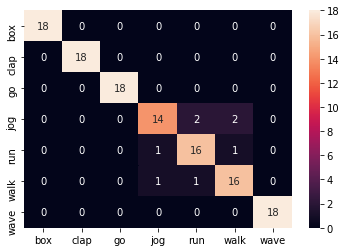

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# CSN 97.62%

In [3]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth \
      -O checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth

--2021-03-28 21:54:04--  https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119580180 (114M) [application/octet-stream]
Saving to: ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’

checkpoints/ircsn_i 100%[===================>] 114,04M  7,32MB/s    in 18s     

2021-03-28 21:54:27 (6,46 MB/s) - ‘checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth’ saved [119580180/119580180]



In [100]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth \
      -O checkpoints/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth

--2021-03-29 21:25:47--  https://download.openmmlab.com/mmaction/recognition/csn/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119580092 (114M) [application/octet-stream]
Saving to: ‘checkpoints/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth’

checkpoints/ircsn_i 100%[===================>] 114,04M  4,39MB/s    in 28s     

2021-03-29 21:26:21 (4,13 MB/s) - ‘checkpoints/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb_20200803-fc66ce8d.pth’ saved [119580092/119580092]



In [55]:
# from mmcv import Config
# cfg = Config.fromfile('./configs/recognition/csn/ircsn_ig65m_pretrained_r152_32x2x1_58e_kinetics400_rgb.py')

In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/csn/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb.py')

In [3]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-CSN'

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


cfg.val_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=32,
        frame_interval=2,
        num_clips=1,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5)
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.test_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=10, test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]



cfg.train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=1),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
#     dict(type='RandomCrop', size=224),
    dict(type='RandomResizedCrop'),
    dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=8

cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dCSN',
        pretrained2d=False,
        pretrained=
        'https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth',
        depth=152,
        with_pool2=False,
        bottleneck_mode='ir',
        norm_eval=True,
        zero_init_residual=False,
        bn_frozen=True,
        in_channels=2),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

In [4]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-31 00:19:33,457 - mmaction - INFO - load model from: https://download.openmmlab.com/mmaction/recognition/csn/ircsn_from_scratch_r152_ig65m_20200807-771c4135.pth
2021-03-31 00:19:33,458 - mmaction - INFO - Use load_from_http loader
2021-03-31 00:19:33,627 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for conv1.conv.weight: copying a param with shape torch.Size([64, 3, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 3, 7, 7]).
2021-03-31 00:19:36,157 - mmaction - INFO - load checkpoint from checkpoints/ircsn_ig65m_pretrained_bnfrozen_r152_32x2x1_58e_kinetics400_rgb_20200812-9037a758.pth
2021-03-31 00:19:36,158 - mmaction - INFO - Use load_from_local loader
2021-03-31 00:19:36,339 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for backbone.conv1.conv.weight: copying a param with shape torch.Size([64, 3, 3, 7, 7]) from checkpoint, the shape in current model is torch.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.5 task/s, elapsed: 7s, ETA:     0s

2021-03-31 00:41:11,735 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 00:41:11,736 - mmaction - INFO - 
top1_acc	0.3413
top5_acc	0.9762
2021-03-31 00:41:11,737 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 00:41:11,738 - mmaction - INFO - 
mean_acc	0.3413
2021-03-31 00:41:12,076 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-31 00:41:12,077 - mmaction - INFO - Best top1_acc is 0.3413 at 5 epoch.
2021-03-31 00:41:12,078 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.3413, top5_acc: 0.9762, mean_class_accuracy: 0.3413
2021-03-31 00:44:27,227 - mmaction - INFO - Epoch [6][100/132]	lr: 3.316e-04, eta: 2:34:28, time: 1.951, data_time: 0.030, memory: 21787, top1_acc: 0.2938, top5_acc: 0.9050, loss_cls: 1.7022, loss: 1.7022, grad_norm: 19.4689
2021-03-31 00:48:42,961 - mmaction - INFO - Epoch [7][100/132]	lr: 4.027e-04, eta: 2:29:59, time: 1.950, data_time: 0.029, memory: 21787, top1_acc: 0.4412, top5_acc: 0.9400,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.6 task/s, elapsed: 7s, ETA:     0s

2021-03-31 01:02:38,583 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 01:02:38,585 - mmaction - INFO - 
top1_acc	0.6508
top5_acc	0.9921
2021-03-31 01:02:38,586 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 01:02:38,588 - mmaction - INFO - 
mean_acc	0.6508
2021-03-31 01:02:38,959 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-31 01:02:38,960 - mmaction - INFO - Best top1_acc is 0.6508 at 10 epoch.
2021-03-31 01:02:38,961 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.6508, top5_acc: 0.9921, mean_class_accuracy: 0.6508
2021-03-31 01:05:54,031 - mmaction - INFO - Epoch [11][100/132]	lr: 7.354e-04, eta: 2:14:22, time: 1.951, data_time: 0.029, memory: 21787, top1_acc: 0.6125, top5_acc: 0.9650, loss_cls: 0.9817, loss: 0.9817, grad_norm: 19.4048
2021-03-31 01:10:09,967 - mmaction - INFO - Epoch [12][100/132]	lr: 8.208e-04, eta: 2:10:44, time: 1.952, data_time: 0.031, memory: 21787, top1_acc: 0.6300, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-03-31 01:24:05,585 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 01:24:05,587 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	0.9921
2021-03-31 01:24:05,587 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 01:24:05,589 - mmaction - INFO - 
mean_acc	0.8095
2021-03-31 01:24:05,961 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-03-31 01:24:05,962 - mmaction - INFO - Best top1_acc is 0.8095 at 15 epoch.
2021-03-31 01:24:05,962 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.8095, top5_acc: 0.9921, mean_class_accuracy: 0.8095
2021-03-31 01:27:20,911 - mmaction - INFO - Epoch [16][100/132]	lr: 1.112e-03, eta: 1:56:42, time: 1.949, data_time: 0.029, memory: 21787, top1_acc: 0.6663, top5_acc: 0.9563, loss_cls: 0.8675, loss: 0.8675, grad_norm: 13.1629
2021-03-31 01:31:36,855 - mmaction - INFO - Epoch [17][100/132]	lr: 1.164e-03, eta: 1:53:16, time: 1.953, data_time: 0.032, memory: 21787, top1_acc: 0.6687, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.9 task/s, elapsed: 7s, ETA:     0s

2021-03-31 01:45:31,966 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 01:45:31,968 - mmaction - INFO - 
top1_acc	0.8254
top5_acc	0.9921
2021-03-31 01:45:31,968 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 01:45:31,969 - mmaction - INFO - 
mean_acc	0.8254
2021-03-31 01:45:32,325 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-03-31 01:45:32,326 - mmaction - INFO - Best top1_acc is 0.8254 at 20 epoch.
2021-03-31 01:45:32,327 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.8254, top5_acc: 0.9921, mean_class_accuracy: 0.8254
2021-03-31 01:48:47,597 - mmaction - INFO - Epoch [21][100/132]	lr: 1.250e-03, eta: 1:39:43, time: 1.953, data_time: 0.031, memory: 21787, top1_acc: 0.6650, top5_acc: 0.9525, loss_cls: 0.8718, loss: 0.8718, grad_norm: 12.2906
2021-03-31 01:53:03,316 - mmaction - INFO - Epoch [22][100/132]	lr: 1.244e-03, eta: 1:36:21, time: 1.951, data_time: 0.029, memory: 21787, top1_acc: 0.6775, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.5 task/s, elapsed: 7s, ETA:     0s

2021-03-31 02:06:58,836 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 02:06:58,837 - mmaction - INFO - 
top1_acc	0.8730
top5_acc	0.9921
2021-03-31 02:06:58,838 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 02:06:58,841 - mmaction - INFO - 
mean_acc	0.8730
2021-03-31 02:06:59,234 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_25.pth.
2021-03-31 02:06:59,235 - mmaction - INFO - Best top1_acc is 0.8730 at 25 epoch.
2021-03-31 02:06:59,236 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.8730, top5_acc: 0.9921, mean_class_accuracy: 0.8730
2021-03-31 02:10:14,284 - mmaction - INFO - Epoch [26][100/132]	lr: 1.158e-03, eta: 1:23:00, time: 1.950, data_time: 0.029, memory: 21787, top1_acc: 0.6863, top5_acc: 0.9675, loss_cls: 0.7419, loss: 0.7419, grad_norm: 11.4448
2021-03-31 02:14:30,088 - mmaction - INFO - Epoch [27][100/132]	lr: 1.122e-03, eta: 1:19:41, time: 1.951, data_time: 0.029, memory: 21787, top1_acc: 0.7163, top5_acc: 0.

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.4 task/s, elapsed: 7s, ETA:     0s

2021-03-31 02:28:25,322 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 02:28:25,323 - mmaction - INFO - 
top1_acc	0.9048
top5_acc	0.9921
2021-03-31 02:28:25,324 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 02:28:25,325 - mmaction - INFO - 
mean_acc	0.9048
2021-03-31 02:28:25,706 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-03-31 02:28:25,707 - mmaction - INFO - Best top1_acc is 0.9048 at 30 epoch.
2021-03-31 02:28:25,708 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.9048, top5_acc: 0.9921, mean_class_accuracy: 0.9048
2021-03-31 02:31:40,756 - mmaction - INFO - Epoch [31][100/132]	lr: 9.289e-04, eta: 1:06:26, time: 1.950, data_time: 0.030, memory: 21787, top1_acc: 0.7200, top5_acc: 0.9637, loss_cls: 0.7187, loss: 0.7187, grad_norm: 9.0214
2021-03-31 02:35:56,706 - mmaction - INFO - Epoch [32][100/132]	lr: 8.713e-04, eta: 1:03:08, time: 1.952, data_time: 0.031, memory: 21787, top1_acc: 0.7362, top5_acc: 0.9

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.7 task/s, elapsed: 7s, ETA:     0s

2021-03-31 02:49:51,978 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 02:49:51,980 - mmaction - INFO - 
top1_acc	0.8968
top5_acc	0.9921
2021-03-31 02:49:51,981 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 02:49:51,983 - mmaction - INFO - 
mean_acc	0.8968
2021-03-31 02:49:51,984 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.8968, top5_acc: 0.9921, mean_class_accuracy: 0.8968
2021-03-31 02:53:07,100 - mmaction - INFO - Epoch [36][100/132]	lr: 6.216e-04, eta: 0:49:57, time: 1.951, data_time: 0.029, memory: 21787, top1_acc: 0.7425, top5_acc: 0.9688, loss_cls: 0.6508, loss: 0.6508, grad_norm: 9.7295
2021-03-31 02:54:07,730 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-03-31 02:57:23,287 - mmaction - INFO - Epoch [37][100/132]	lr: 5.576e-04, eta: 0:46:40, time: 1.952, data_time: 0.030, memory: 21787, top1_acc: 0.7588, top5_acc: 0.9725, loss_cls: 0.6332, loss: 0.6332, grad_norm: 10.7476
2021-03-31 03:01:39,091 - mmaction - INFO - Epoch [38]

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.8 task/s, elapsed: 7s, ETA:     0s

2021-03-31 03:11:18,639 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 03:11:18,641 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	0.9921
2021-03-31 03:11:18,642 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 03:11:18,643 - mmaction - INFO - 
mean_acc	0.8571
2021-03-31 03:11:18,644 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.8571, top5_acc: 0.9921, mean_class_accuracy: 0.8571
2021-03-31 03:14:33,736 - mmaction - INFO - Epoch [41][100/132]	lr: 3.152e-04, eta: 0:33:32, time: 1.951, data_time: 0.029, memory: 21787, top1_acc: 0.7600, top5_acc: 0.9700, loss_cls: 0.6333, loss: 0.6333, grad_norm: 10.3063
2021-03-31 03:18:49,499 - mmaction - INFO - Epoch [42][100/132]	lr: 2.612e-04, eta: 0:30:15, time: 1.952, data_time: 0.030, memory: 21787, top1_acc: 0.7887, top5_acc: 0.9725, loss_cls: 0.6009, loss: 0.6009, grad_norm: 9.9502
2021-03-31 03:23:05,287 - mmaction - INFO - Epoch [43][100/132]	lr: 2.110e-04, eta: 0:26:59, time: 1.952, data_time: 0.031, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.5 task/s, elapsed: 7s, ETA:     0s

2021-03-31 03:32:44,908 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 03:32:44,909 - mmaction - INFO - 
top1_acc	0.8889
top5_acc	0.9921
2021-03-31 03:32:44,910 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 03:32:44,911 - mmaction - INFO - 
mean_acc	0.8889
2021-03-31 03:32:44,911 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.8889, top5_acc: 0.9921, mean_class_accuracy: 0.8889
2021-03-31 03:36:00,053 - mmaction - INFO - Epoch [46][100/132]	lr: 8.858e-05, eta: 0:17:09, time: 1.951, data_time: 0.030, memory: 21787, top1_acc: 0.7525, top5_acc: 0.9688, loss_cls: 0.6210, loss: 0.6210, grad_norm: 10.5199
2021-03-31 03:40:15,735 - mmaction - INFO - Epoch [47][100/132]	lr: 5.854e-05, eta: 0:13:52, time: 1.950, data_time: 0.029, memory: 21787, top1_acc: 0.7900, top5_acc: 0.9700, loss_cls: 0.5427, loss: 0.5427, grad_norm: 9.7076
2021-03-31 03:44:31,750 - mmaction - INFO - Epoch [48][100/132]	lr: 3.446e-05, eta: 0:10:36, time: 1.953, data_time: 0.031, memor

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.4 task/s, elapsed: 7s, ETA:     0s

2021-03-31 03:54:12,138 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 03:54:12,140 - mmaction - INFO - 
top1_acc	0.8968
top5_acc	0.9921
2021-03-31 03:54:12,141 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 03:54:12,143 - mmaction - INFO - 
mean_acc	0.8968
2021-03-31 03:54:12,144 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.8968, top5_acc: 0.9921, mean_class_accuracy: 0.8968
2021-03-31 03:57:27,564 - mmaction - INFO - Epoch [51][100/132]	lr: 2.070e-07, eta: 0:00:47, time: 1.954, data_time: 0.029, memory: 21787, top1_acc: 0.7625, top5_acc: 0.9738, loss_cls: 0.5954, loss: 0.5954, grad_norm: 9.0673


In [5]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [6]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.7 task/s, elapsed: 183s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9762
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9762
top1_acc: 0.9762
top5_acc: 1.0000
mean_class_accuracy: 0.9762


<AxesSubplot:>

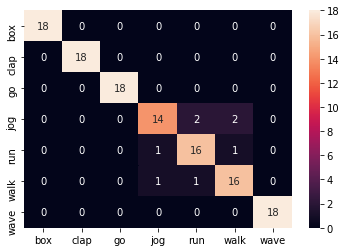

In [19]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# TANet 96.03%

In [1]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tanet/tanet_r50_dense_1x1x8_100e_kinetics400_rgb/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth \
      -O checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth

--2021-03-29 00:29:51--  https://download.openmmlab.com/mmaction/recognition/tanet/tanet_r50_dense_1x1x8_100e_kinetics400_rgb/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102681749 (98M) [application/octet-stream]
Saving to: ‘checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth’

checkpoints/tanet_r 100%[===================>]  97,92M  11,1MB/s    in 9,1s    

2021-03-29 00:30:03 (10,8 MB/s) - ‘checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth’ saved [102681749/102681749]



In [84]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tanet/tanet_r50_dense_1x1x8_100e_kinetics400_rgb.py')

In [85]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-TANet'

# cfg.train_pipeline[1] = dict(type='RawFrameDecode')
# cfg.test_pipeline[1] = dict(type='RawFrameDecode')
# cfg.val_pipeline[1] = dict(type='RawFrameDecode')

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])

cfg.train_pipeline[7].input_format = 'NCHW_Flow'
cfg.test_pipeline[5].input_format = 'NCHW_Flow'
cfg.val_pipeline[5].input_format = 'NCHW_Flow'

cfg.train_pipeline[6] = dict(type='Normalize', mean=[128, 128], std=[128, 128])
cfg.test_pipeline[4] = dict(type='Normalize', mean=[128, 128], std=[128, 128])
cfg.val_pipeline[4] = dict(type='Normalize', mean=[128, 128], std=[128, 128])

# cfg.train_pipeline[0].clip_len = 1
# cfg.test_pipeline[0].clip_len = 1
# cfg.val_pipeline[0].clip_len = 1

# cfg.train_pipeline[0] = dict(
#         type='SampleFrames',
#         clip_len=3,
#         frame_interval=1,
#         num_clips=25)
# cfg.test_pipeline[0] = dict(
#         type='SampleFrames',
#         clip_len=5,
#         frame_interval=1,
#         num_clips=3,
#         test_mode=True)
# cfg.val_pipeline[0] = dict(
#         type='SampleFrames',
#         clip_len=5,
#         frame_interval=1,
#         num_clips=25,
#         test_mode=True)

cfg.train_pipeline[3] = dict(type='RandomResizedCrop')

del cfg.train_pipeline[5]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline
# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
# cfg.data.videos_per_gpu = 24
# cfg.optimizer.type = 'Adam'
# cfg.optimizer.weight_decay=0.0001

# cfg.optimizer_config.grad_clip=None
# cfg.optimizer.lr = 0.01

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.img_norm_cfg.mean = [0.485, 0.456, 0.406]
# cfg.img_norm_cfg.std = [0.229, 0.224, 0.225]

# cfg.train_pipeline[6] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
# cfg.test_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
# cfg.val_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)

cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='TANet',
        pretrained='torchvision://resnet50',
        depth=50,
        num_segments=8,
        tam_cfg=dict(),
        in_channels=2),
    cls_head=dict(
        type='TSMHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.5,
        init_std=0.001),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=12)
log_config = dict(interval=25, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth'
resume_from = None
workflow = [('train', 1)]
dataset_type = 'RawframeDataset'
data_root = 'data/childact_rawframe/train/'
data_root_val = 'data/childact_rawframe/val/'
ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
ann

In [86]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-29 12:18:39,908 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.bias', 'fc.weight', 'conv1.weight'}


Use load_from_torchvision loader


2021-03-29 12:18:39,999 - mmaction - INFO - load checkpoint from checkpoints/tanet_r50_dense_1x1x8_100e_kinetics400_rgb_20210219-032c8e94.pth
2021-03-29 12:18:40,000 - mmaction - INFO - Use load_from_local loader
2021-03-29 12:18:40,088 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for backbone.conv1.conv.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 7, 7]).
size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-29 12:18:40,090 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-TANet
2021-03-2

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 9.2 task/s, elapsed: 14s, ETA:     0s

2021-03-29 12:20:10,521 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:20:10,523 - mmaction - INFO - 
top1_acc	0.7460
top5_acc	0.9921
2021-03-29 12:20:10,524 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:20:10,526 - mmaction - INFO - 
mean_acc	0.7460
2021-03-29 12:20:10,814 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_2.pth.
2021-03-29 12:20:10,816 - mmaction - INFO - Best top1_acc is 0.7460 at 2 epoch.
2021-03-29 12:20:10,816 - mmaction - INFO - Epoch(val) [2][132]	top1_acc: 0.7460, top5_acc: 0.9921, mean_class_accuracy: 0.7460
2021-03-29 12:20:20,084 - mmaction - INFO - Epoch [3][25/132]	lr: 1.252e-02, eta: 0:30:33, time: 0.371, data_time: 0.096, memory: 7542, top1_acc: 0.4850, top5_acc: 0.9400, loss_cls: 1.3050, loss: 1.3050, grad_norm: 3.2627
2021-03-29 12:20:26,945 - mmaction - INFO - Epoch [3][50/132]	lr: 1.297e-02, eta: 0:30:20, time: 0.274, data_time: 0.000, memory: 7542, top1_acc: 0.5000, top5_acc: 0.9250, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.8 task/s, elapsed: 14s, ETA:     0s

2021-03-29 12:21:42,394 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:21:42,396 - mmaction - INFO - 
top1_acc	0.7857
top5_acc	1.0000
2021-03-29 12:21:42,396 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:21:42,398 - mmaction - INFO - 
mean_acc	0.7857
2021-03-29 12:21:42,718 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_4.pth.
2021-03-29 12:21:42,719 - mmaction - INFO - Best top1_acc is 0.7857 at 4 epoch.
2021-03-29 12:21:42,719 - mmaction - INFO - Epoch(val) [4][132]	top1_acc: 0.7857, top5_acc: 1.0000, mean_class_accuracy: 0.7857
2021-03-29 12:21:52,074 - mmaction - INFO - Epoch [5][25/132]	lr: 1.902e-02, eta: 0:29:00, time: 0.374, data_time: 0.098, memory: 7542, top1_acc: 0.5150, top5_acc: 0.9600, loss_cls: 1.1166, loss: 1.1166, grad_norm: 2.8345
2021-03-29 12:21:58,959 - mmaction - INFO - Epoch [5][50/132]	lr: 1.982e-02, eta: 0:28:51, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.5700, top5_acc: 0.9500, loss

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 9.0 task/s, elapsed: 14s, ETA:     0s

2021-03-29 12:23:14,235 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:23:14,237 - mmaction - INFO - 
top1_acc	0.7063
top5_acc	0.9921
2021-03-29 12:23:14,238 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:23:14,240 - mmaction - INFO - 
mean_acc	0.7063
2021-03-29 12:23:14,241 - mmaction - INFO - Epoch(val) [6][132]	top1_acc: 0.7063, top5_acc: 0.9921, mean_class_accuracy: 0.7063
2021-03-29 12:23:23,577 - mmaction - INFO - Epoch [7][25/132]	lr: 2.891e-02, eta: 0:27:42, time: 0.373, data_time: 0.096, memory: 7542, top1_acc: 0.4950, top5_acc: 0.9550, loss_cls: 1.2765, loss: 1.2765, grad_norm: 3.5840
2021-03-29 12:23:30,468 - mmaction - INFO - Epoch [7][50/132]	lr: 2.999e-02, eta: 0:27:34, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.5400, top5_acc: 0.9750, loss_cls: 1.1278, loss: 1.1278, grad_norm: 2.6806
2021-03-29 12:23:37,361 - mmaction - INFO - Epoch [7][75/132]	lr: 3.109e-02, eta: 0:27:26, time: 0.276, data_time: 0.000, memory: 7542, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.7 task/s, elapsed: 14s, ETA:     0s

2021-03-29 12:24:46,285 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:24:46,286 - mmaction - INFO - 
top1_acc	0.7381
top5_acc	0.9921
2021-03-29 12:24:46,287 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:24:46,287 - mmaction - INFO - 
mean_acc	0.7381
2021-03-29 12:24:46,288 - mmaction - INFO - Epoch(val) [8][132]	top1_acc: 0.7381, top5_acc: 0.9921, mean_class_accuracy: 0.7381
2021-03-29 12:24:55,618 - mmaction - INFO - Epoch [9][25/132]	lr: 4.125e-02, eta: 0:26:26, time: 0.373, data_time: 0.096, memory: 7542, top1_acc: 0.5800, top5_acc: 0.9550, loss_cls: 1.0139, loss: 1.0139, grad_norm: 2.1394
2021-03-29 12:25:02,513 - mmaction - INFO - Epoch [9][50/132]	lr: 4.251e-02, eta: 0:26:18, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.6100, top5_acc: 0.9350, loss_cls: 1.0128, loss: 1.0128, grad_norm: 2.0550
2021-03-29 12:25:09,412 - mmaction - INFO - Epoch [9][75/132]	lr: 4.378e-02, eta: 0:26:11, time: 0.276, data_time: 0.000, memory: 7542, t

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.4 task/s, elapsed: 15s, ETA:     0s

2021-03-29 12:26:19,308 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:26:19,310 - mmaction - INFO - 
top1_acc	0.7619
top5_acc	1.0000
2021-03-29 12:26:19,311 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:26:19,314 - mmaction - INFO - 
mean_acc	0.7619
2021-03-29 12:26:19,315 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.7619, top5_acc: 1.0000, mean_class_accuracy: 0.7619
2021-03-29 12:26:28,658 - mmaction - INFO - Epoch [11][25/132]	lr: 5.489e-02, eta: 0:25:13, time: 0.373, data_time: 0.096, memory: 7542, top1_acc: 0.5850, top5_acc: 0.9500, loss_cls: 1.0882, loss: 1.0882, grad_norm: 1.8450
2021-03-29 12:26:35,554 - mmaction - INFO - Epoch [11][50/132]	lr: 5.621e-02, eta: 0:25:05, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.6550, top5_acc: 0.9600, loss_cls: 0.9252, loss: 0.9252, grad_norm: 1.7665
2021-03-29 12:26:42,452 - mmaction - INFO - Epoch [11][75/132]	lr: 5.752e-02, eta: 0:24:58, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.7 task/s, elapsed: 16s, ETA:     0s

2021-03-29 12:27:53,690 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:27:53,692 - mmaction - INFO - 
top1_acc	0.7857
top5_acc	0.9921
2021-03-29 12:27:53,692 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:27:53,694 - mmaction - INFO - 
mean_acc	0.7857
2021-03-29 12:27:53,694 - mmaction - INFO - Epoch(val) [12][132]	top1_acc: 0.7857, top5_acc: 0.9921, mean_class_accuracy: 0.7857
2021-03-29 12:28:03,444 - mmaction - INFO - Epoch [13][25/132]	lr: 6.855e-02, eta: 0:23:59, time: 0.390, data_time: 0.096, memory: 7542, top1_acc: 0.5400, top5_acc: 0.9350, loss_cls: 1.1494, loss: 1.1494, grad_norm: 1.7940
2021-03-29 12:28:10,649 - mmaction - INFO - Epoch [13][50/132]	lr: 6.979e-02, eta: 0:23:52, time: 0.288, data_time: 0.000, memory: 7542, top1_acc: 0.6300, top5_acc: 0.9650, loss_cls: 1.0300, loss: 1.0300, grad_norm: 1.6314
2021-03-29 12:28:17,824 - mmaction - INFO - Epoch [13][75/132]	lr: 7.103e-02, eta: 0:23:46, time: 0.287, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 4.9 task/s, elapsed: 26s, ETA:     0s

2021-03-29 12:29:38,320 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:29:38,322 - mmaction - INFO - 
top1_acc	0.7540
top5_acc	1.0000
2021-03-29 12:29:38,323 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:29:38,324 - mmaction - INFO - 
mean_acc	0.7540
2021-03-29 12:29:38,325 - mmaction - INFO - Epoch(val) [14][132]	top1_acc: 0.7540, top5_acc: 1.0000, mean_class_accuracy: 0.7540
2021-03-29 12:29:47,604 - mmaction - INFO - Epoch [15][25/132]	lr: 8.092e-02, eta: 0:22:46, time: 0.371, data_time: 0.095, memory: 7542, top1_acc: 0.6250, top5_acc: 0.9800, loss_cls: 1.1604, loss: 1.1604, grad_norm: 1.8526
2021-03-29 12:29:54,470 - mmaction - INFO - Epoch [15][50/132]	lr: 8.198e-02, eta: 0:22:39, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.6350, top5_acc: 0.9650, loss_cls: 0.9313, loss: 0.9313, grad_norm: 1.5301
2021-03-29 12:30:01,372 - mmaction - INFO - Epoch [15][75/132]	lr: 8.302e-02, eta: 0:22:31, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.6 task/s, elapsed: 19s, ETA:     0s

2021-03-29 12:31:15,268 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:31:15,270 - mmaction - INFO - 
top1_acc	0.7063
top5_acc	0.9762
2021-03-29 12:31:15,270 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:31:15,271 - mmaction - INFO - 
mean_acc	0.7063
2021-03-29 12:31:15,271 - mmaction - INFO - Epoch(val) [16][132]	top1_acc: 0.7063, top5_acc: 0.9762, mean_class_accuracy: 0.7063
2021-03-29 12:31:24,767 - mmaction - INFO - Epoch [17][25/132]	lr: 9.085e-02, eta: 0:21:32, time: 0.380, data_time: 0.096, memory: 7542, top1_acc: 0.6550, top5_acc: 0.9700, loss_cls: 0.8708, loss: 0.8708, grad_norm: 1.3874
2021-03-29 12:31:31,719 - mmaction - INFO - Epoch [17][50/132]	lr: 9.163e-02, eta: 0:21:25, time: 0.278, data_time: 0.000, memory: 7542, top1_acc: 0.6100, top5_acc: 0.9750, loss_cls: 1.0270, loss: 1.0270, grad_norm: 1.7035
2021-03-29 12:31:38,611 - mmaction - INFO - Epoch [17][75/132]	lr: 9.238e-02, eta: 0:21:17, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.2 task/s, elapsed: 18s, ETA:     0s

2021-03-29 12:32:50,652 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:32:50,655 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-29 12:32:50,655 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:32:50,656 - mmaction - INFO - 
mean_acc	0.8016
2021-03-29 12:32:50,980 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_18.pth.
2021-03-29 12:32:50,981 - mmaction - INFO - Best top1_acc is 0.8016 at 18 epoch.
2021-03-29 12:32:50,982 - mmaction - INFO - Epoch(val) [18][132]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-29 12:33:00,329 - mmaction - INFO - Epoch [19][25/132]	lr: 9.741e-02, eta: 0:20:17, time: 0.374, data_time: 0.097, memory: 7542, top1_acc: 0.6100, top5_acc: 0.9600, loss_cls: 1.0305, loss: 1.0305, grad_norm: 1.4992
2021-03-29 12:33:07,215 - mmaction - INFO - Epoch [19][50/132]	lr: 9.783e-02, eta: 0:20:10, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.5650, top5_acc: 0.9700,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-29 12:34:23,751 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:34:23,754 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	0.9921
2021-03-29 12:34:23,755 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:34:23,757 - mmaction - INFO - 
mean_acc	0.8571
2021-03-29 12:34:24,084 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_20.pth.
2021-03-29 12:34:24,085 - mmaction - INFO - Best top1_acc is 0.8571 at 20 epoch.
2021-03-29 12:34:24,086 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.8571, top5_acc: 0.9921, mean_class_accuracy: 0.8571
2021-03-29 12:34:33,385 - mmaction - INFO - Epoch [21][25/132]	lr: 9.998e-02, eta: 0:19:02, time: 0.372, data_time: 0.095, memory: 7542, top1_acc: 0.6450, top5_acc: 0.9550, loss_cls: 0.9383, loss: 0.9383, grad_norm: 1.4433
2021-03-29 12:34:40,270 - mmaction - INFO - Epoch [21][50/132]	lr: 1.000e-01, eta: 0:18:55, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.5950, top5_acc: 0.9650,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.3 task/s, elapsed: 17s, ETA:     0s

2021-03-29 12:35:58,993 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:35:58,995 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-03-29 12:35:58,995 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:35:58,997 - mmaction - INFO - 
mean_acc	0.8571
2021-03-29 12:35:58,998 - mmaction - INFO - Epoch(val) [22][132]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-03-29 12:36:08,389 - mmaction - INFO - Epoch [23][25/132]	lr: 9.916e-02, eta: 0:17:47, time: 0.375, data_time: 0.097, memory: 7542, top1_acc: 0.6350, top5_acc: 0.9450, loss_cls: 1.0547, loss: 1.0547, grad_norm: 1.5259
2021-03-29 12:36:15,277 - mmaction - INFO - Epoch [23][50/132]	lr: 9.897e-02, eta: 0:17:40, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.6650, top5_acc: 0.9750, loss_cls: 0.8709, loss: 0.8709, grad_norm: 1.4287
2021-03-29 12:36:22,169 - mmaction - INFO - Epoch [23][75/132]	lr: 9.877e-02, eta: 0:17:33, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.9 task/s, elapsed: 16s, ETA:     0s

2021-03-29 12:37:33,029 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:37:33,032 - mmaction - INFO - 
top1_acc	0.8413
top5_acc	1.0000
2021-03-29 12:37:33,033 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:37:33,035 - mmaction - INFO - 
mean_acc	0.8413
2021-03-29 12:37:33,036 - mmaction - INFO - Epoch(val) [24][132]	top1_acc: 0.8413, top5_acc: 1.0000, mean_class_accuracy: 0.8413
2021-03-29 12:37:42,529 - mmaction - INFO - Epoch [25][25/132]	lr: 9.627e-02, eta: 0:16:33, time: 0.379, data_time: 0.100, memory: 7542, top1_acc: 0.6400, top5_acc: 0.9750, loss_cls: 0.9685, loss: 0.9685, grad_norm: 1.3406
2021-03-29 12:37:49,424 - mmaction - INFO - Epoch [25][50/132]	lr: 9.589e-02, eta: 0:16:26, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.5750, top5_acc: 0.9700, loss_cls: 0.9444, loss: 0.9444, grad_norm: 1.2980
2021-03-29 12:37:56,313 - mmaction - INFO - Epoch [25][75/132]	lr: 9.550e-02, eta: 0:16:19, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 5.5 task/s, elapsed: 23s, ETA:     0s

2021-03-29 12:39:13,616 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:39:13,618 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-29 12:39:13,619 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:39:13,621 - mmaction - INFO - 
mean_acc	0.8016
2021-03-29 12:39:13,622 - mmaction - INFO - Epoch(val) [26][132]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-29 12:39:23,141 - mmaction - INFO - Epoch [27][25/132]	lr: 9.143e-02, eta: 0:15:19, time: 0.381, data_time: 0.096, memory: 7542, top1_acc: 0.5750, top5_acc: 0.9600, loss_cls: 1.0374, loss: 1.0374, grad_norm: 1.5633
2021-03-29 12:39:30,041 - mmaction - INFO - Epoch [27][50/132]	lr: 9.088e-02, eta: 0:15:12, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.7050, top5_acc: 0.9650, loss_cls: 0.8179, loss: 0.8179, grad_norm: 1.2858
2021-03-29 12:39:36,928 - mmaction - INFO - Epoch [27][75/132]	lr: 9.031e-02, eta: 0:15:05, time: 0.275, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.2 task/s, elapsed: 20s, ETA:     0s

2021-03-29 12:40:51,587 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:40:51,589 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-29 12:40:51,590 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:40:51,592 - mmaction - INFO - 
mean_acc	0.8016
2021-03-29 12:40:51,593 - mmaction - INFO - Epoch(val) [28][132]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-29 12:41:00,931 - mmaction - INFO - Epoch [29][25/132]	lr: 8.486e-02, eta: 0:14:05, time: 0.373, data_time: 0.096, memory: 7542, top1_acc: 0.6900, top5_acc: 0.9850, loss_cls: 0.8418, loss: 0.8418, grad_norm: 1.3215
2021-03-29 12:41:07,813 - mmaction - INFO - Epoch [29][50/132]	lr: 8.415e-02, eta: 0:13:57, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.6900, top5_acc: 0.9750, loss_cls: 0.8487, loss: 0.8487, grad_norm: 1.4120
2021-03-29 12:41:14,700 - mmaction - INFO - Epoch [29][75/132]	lr: 8.344e-02, eta: 0:13:50, time: 0.275, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.9 task/s, elapsed: 16s, ETA:     0s

2021-03-29 12:42:25,226 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:42:25,228 - mmaction - INFO - 
top1_acc	0.6984
top5_acc	1.0000
2021-03-29 12:42:25,229 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:42:25,230 - mmaction - INFO - 
mean_acc	0.6984
2021-03-29 12:42:25,231 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.6984, top5_acc: 1.0000, mean_class_accuracy: 0.6984
2021-03-29 12:42:34,678 - mmaction - INFO - Epoch [31][25/132]	lr: 7.682e-02, eta: 0:12:50, time: 0.378, data_time: 0.097, memory: 7542, top1_acc: 0.6250, top5_acc: 0.9650, loss_cls: 0.9535, loss: 0.9535, grad_norm: 1.2246
2021-03-29 12:42:41,679 - mmaction - INFO - Epoch [31][50/132]	lr: 7.599e-02, eta: 0:12:43, time: 0.280, data_time: 0.000, memory: 7542, top1_acc: 0.5900, top5_acc: 0.9750, loss_cls: 0.8822, loss: 0.8822, grad_norm: 1.2808
2021-03-29 12:42:49,007 - mmaction - INFO - Epoch [31][75/132]	lr: 7.516e-02, eta: 0:12:37, time: 0.293, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.4 task/s, elapsed: 17s, ETA:     0s

2021-03-29 12:44:01,109 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:44:01,111 - mmaction - INFO - 
top1_acc	0.8730
top5_acc	1.0000
2021-03-29 12:44:01,112 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:44:01,113 - mmaction - INFO - 
mean_acc	0.8730
2021-03-29 12:44:01,430 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_32.pth.
2021-03-29 12:44:01,431 - mmaction - INFO - Best top1_acc is 0.8730 at 32 epoch.
2021-03-29 12:44:01,432 - mmaction - INFO - Epoch(val) [32][132]	top1_acc: 0.8730, top5_acc: 1.0000, mean_class_accuracy: 0.8730
2021-03-29 12:44:10,830 - mmaction - INFO - Epoch [33][25/132]	lr: 6.765e-02, eta: 0:11:37, time: 0.376, data_time: 0.096, memory: 7542, top1_acc: 0.6750, top5_acc: 0.9800, loss_cls: 0.7608, loss: 0.7608, grad_norm: 1.3078
2021-03-29 12:44:17,767 - mmaction - INFO - Epoch [33][50/132]	lr: 6.674e-02, eta: 0:11:30, time: 0.277, data_time: 0.000, memory: 7542, top1_acc: 0.6350, top5_acc: 0.9700,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 6.2 task/s, elapsed: 20s, ETA:     0s

2021-03-29 12:45:39,709 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:45:39,711 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-03-29 12:45:39,712 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:45:39,713 - mmaction - INFO - 
mean_acc	0.8016
2021-03-29 12:45:39,714 - mmaction - INFO - Epoch(val) [34][132]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-03-29 12:45:49,041 - mmaction - INFO - Epoch [35][25/132]	lr: 5.774e-02, eta: 0:10:23, time: 0.373, data_time: 0.095, memory: 7542, top1_acc: 0.7150, top5_acc: 0.9750, loss_cls: 0.7551, loss: 0.7551, grad_norm: 1.3288
2021-03-29 12:45:55,947 - mmaction - INFO - Epoch [35][50/132]	lr: 5.678e-02, eta: 0:10:16, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.6100, top5_acc: 0.9800, loss_cls: 0.9415, loss: 0.9415, grad_norm: 1.4335
2021-03-29 12:46:02,847 - mmaction - INFO - Epoch [35][75/132]	lr: 5.582e-02, eta: 0:10:09, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.8 task/s, elapsed: 16s, ETA:     0s

2021-03-29 12:47:13,822 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:47:13,824 - mmaction - INFO - 
top1_acc	0.7778
top5_acc	1.0000
2021-03-29 12:47:13,824 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:47:13,826 - mmaction - INFO - 
mean_acc	0.7778
2021-03-29 12:47:13,827 - mmaction - INFO - Epoch(val) [36][132]	top1_acc: 0.7778, top5_acc: 1.0000, mean_class_accuracy: 0.7778
2021-03-29 12:47:23,158 - mmaction - INFO - Epoch [37][25/132]	lr: 4.751e-02, eta: 0:09:08, time: 0.373, data_time: 0.096, memory: 7542, top1_acc: 0.7100, top5_acc: 0.9750, loss_cls: 0.7372, loss: 0.7372, grad_norm: 1.1137
2021-03-29 12:47:30,048 - mmaction - INFO - Epoch [37][50/132]	lr: 4.654e-02, eta: 0:09:01, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.7350, top5_acc: 0.9700, loss_cls: 0.6571, loss: 0.6571, grad_norm: 1.0894
2021-03-29 12:47:36,945 - mmaction - INFO - Epoch [37][75/132]	lr: 4.557e-02, eta: 0:08:54, time: 0.276, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.2 task/s, elapsed: 15s, ETA:     0s

2021-03-29 12:48:46,678 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:48:46,679 - mmaction - INFO - 
top1_acc	0.8889
top5_acc	1.0000
2021-03-29 12:48:46,680 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:48:46,681 - mmaction - INFO - 
mean_acc	0.8889
2021-03-29 12:48:46,987 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_38.pth.
2021-03-29 12:48:46,988 - mmaction - INFO - Best top1_acc is 0.8889 at 38 epoch.
2021-03-29 12:48:46,988 - mmaction - INFO - Epoch(val) [38][132]	top1_acc: 0.8889, top5_acc: 1.0000, mean_class_accuracy: 0.8889
2021-03-29 12:48:56,353 - mmaction - INFO - Epoch [39][25/132]	lr: 3.738e-02, eta: 0:07:54, time: 0.374, data_time: 0.098, memory: 7542, top1_acc: 0.7200, top5_acc: 0.9800, loss_cls: 0.7111, loss: 0.7111, grad_norm: 1.0545
2021-03-29 12:49:03,252 - mmaction - INFO - Epoch [39][50/132]	lr: 3.645e-02, eta: 0:07:47, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.7000, top5_acc: 0.9800,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 5.9 task/s, elapsed: 21s, ETA:     0s

2021-03-29 12:50:25,956 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:50:25,958 - mmaction - INFO - 
top1_acc	0.8968
top5_acc	1.0000
2021-03-29 12:50:25,959 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:50:25,960 - mmaction - INFO - 
mean_acc	0.8968
2021-03-29 12:50:26,280 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-29 12:50:26,281 - mmaction - INFO - Best top1_acc is 0.8968 at 40 epoch.
2021-03-29 12:50:26,282 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.8968, top5_acc: 1.0000, mean_class_accuracy: 0.8968
2021-03-29 12:50:35,651 - mmaction - INFO - Epoch [41][25/132]	lr: 2.779e-02, eta: 0:06:40, time: 0.375, data_time: 0.098, memory: 7542, top1_acc: 0.7900, top5_acc: 0.9800, loss_cls: 0.6404, loss: 0.6404, grad_norm: 1.0543
2021-03-29 12:50:42,536 - mmaction - INFO - Epoch [41][50/132]	lr: 2.692e-02, eta: 0:06:33, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.7050, top5_acc: 0.9600,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 7.3 task/s, elapsed: 17s, ETA:     0s

2021-03-29 12:52:01,100 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:52:01,101 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-03-29 12:52:01,102 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:52:01,103 - mmaction - INFO - 
mean_acc	0.9206
2021-03-29 12:52:01,409 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_42.pth.
2021-03-29 12:52:01,410 - mmaction - INFO - Best top1_acc is 0.9206 at 42 epoch.
2021-03-29 12:52:01,411 - mmaction - INFO - Epoch(val) [42][132]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-03-29 12:52:10,768 - mmaction - INFO - Epoch [43][25/132]	lr: 1.912e-02, eta: 0:05:26, time: 0.374, data_time: 0.098, memory: 7542, top1_acc: 0.7450, top5_acc: 0.9950, loss_cls: 0.5536, loss: 0.5536, grad_norm: 1.0520
2021-03-29 12:52:17,707 - mmaction - INFO - Epoch [43][50/132]	lr: 1.836e-02, eta: 0:05:19, time: 0.278, data_time: 0.000, memory: 7542, top1_acc: 0.7400, top5_acc: 0.9800,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-29 12:53:34,189 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:53:34,191 - mmaction - INFO - 
top1_acc	0.9365
top5_acc	1.0000
2021-03-29 12:53:34,192 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:53:34,194 - mmaction - INFO - 
mean_acc	0.9365
2021-03-29 12:53:34,515 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_44.pth.
2021-03-29 12:53:34,516 - mmaction - INFO - Best top1_acc is 0.9365 at 44 epoch.
2021-03-29 12:53:34,516 - mmaction - INFO - Epoch(val) [44][132]	top1_acc: 0.9365, top5_acc: 1.0000, mean_class_accuracy: 0.9365
2021-03-29 12:53:43,861 - mmaction - INFO - Epoch [45][25/132]	lr: 1.175e-02, eta: 0:04:12, time: 0.374, data_time: 0.097, memory: 7542, top1_acc: 0.7250, top5_acc: 0.9750, loss_cls: 0.7311, loss: 0.7311, grad_norm: 1.2606
2021-03-29 12:53:50,752 - mmaction - INFO - Epoch [45][50/132]	lr: 1.113e-02, eta: 0:04:05, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.6950, top5_acc: 0.9900,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 4.5 task/s, elapsed: 28s, ETA:     0s

2021-03-29 12:55:20,084 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:55:20,086 - mmaction - INFO - 
top1_acc	0.9048
top5_acc	1.0000
2021-03-29 12:55:20,086 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:55:20,088 - mmaction - INFO - 
mean_acc	0.9048
2021-03-29 12:55:20,089 - mmaction - INFO - Epoch(val) [46][132]	top1_acc: 0.9048, top5_acc: 1.0000, mean_class_accuracy: 0.9048
2021-03-29 12:55:29,408 - mmaction - INFO - Epoch [47][25/132]	lr: 5.991e-03, eta: 0:02:58, time: 0.373, data_time: 0.096, memory: 7542, top1_acc: 0.7600, top5_acc: 0.9700, loss_cls: 0.6438, loss: 0.6438, grad_norm: 1.1836
2021-03-29 12:55:36,285 - mmaction - INFO - Epoch [47][50/132]	lr: 5.538e-03, eta: 0:02:51, time: 0.275, data_time: 0.000, memory: 7542, top1_acc: 0.6950, top5_acc: 0.9750, loss_cls: 0.6791, loss: 0.6791, grad_norm: 1.2062
2021-03-29 12:55:43,171 - mmaction - INFO - Epoch [47][75/132]	lr: 5.102e-03, eta: 0:02:44, time: 0.275, data_time: 0.000, memory: 754

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.3 task/s, elapsed: 15s, ETA:     0s

2021-03-29 12:56:53,000 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:56:53,002 - mmaction - INFO - 
top1_acc	0.9444
top5_acc	1.0000
2021-03-29 12:56:53,002 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:56:53,003 - mmaction - INFO - 
mean_acc	0.9444
2021-03-29 12:56:53,309 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_48.pth.
2021-03-29 12:56:53,310 - mmaction - INFO - Best top1_acc is 0.9444 at 48 epoch.
2021-03-29 12:56:53,311 - mmaction - INFO - Epoch(val) [48][132]	top1_acc: 0.9444, top5_acc: 1.0000, mean_class_accuracy: 0.9444
2021-03-29 12:57:02,606 - mmaction - INFO - Epoch [49][25/132]	lr: 2.078e-03, eta: 0:01:44, time: 0.372, data_time: 0.095, memory: 7542, top1_acc: 0.6650, top5_acc: 0.9600, loss_cls: 0.6950, loss: 0.6950, grad_norm: 1.2440
2021-03-29 12:57:09,496 - mmaction - INFO - Epoch [49][50/132]	lr: 1.809e-03, eta: 0:01:37, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.7600, top5_acc: 0.9950,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 8.2 task/s, elapsed: 15s, ETA:     0s

2021-03-29 12:58:26,284 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 12:58:26,286 - mmaction - INFO - 
top1_acc	0.9365
top5_acc	1.0000
2021-03-29 12:58:26,286 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 12:58:26,287 - mmaction - INFO - 
mean_acc	0.9365
2021-03-29 12:58:26,287 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.9365, top5_acc: 1.0000, mean_class_accuracy: 0.9365
2021-03-29 12:58:35,659 - mmaction - INFO - Epoch [51][25/132]	lr: 1.763e-04, eta: 0:00:30, time: 0.375, data_time: 0.098, memory: 7542, top1_acc: 0.7600, top5_acc: 0.9750, loss_cls: 0.6415, loss: 0.6415, grad_norm: 1.1715
2021-03-29 12:58:42,555 - mmaction - INFO - Epoch [51][50/132]	lr: 1.042e-04, eta: 0:00:22, time: 0.276, data_time: 0.000, memory: 7542, top1_acc: 0.7450, top5_acc: 0.9800, loss_cls: 0.6178, loss: 0.6178, grad_norm: 1.2646
2021-03-29 12:58:49,449 - mmaction - INFO - Epoch [51][75/132]	lr: 5.095e-05, eta: 0:00:15, time: 0.276, data_time: 0.000, memory: 754

In [87]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [88]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 2.5 task/s, elapsed: 50s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9603
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9603
top1_acc: 0.9603
top5_acc: 1.0000
mean_class_accuracy: 0.9603


<AxesSubplot:>

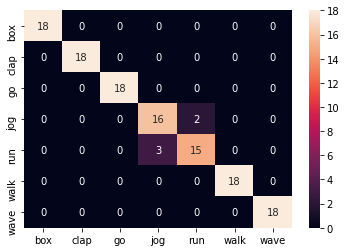

In [89]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# TPN 96.83%

In [108]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tpn/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth \
      -O checkpoints/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth

--2021-03-29 21:56:37--  https://download.openmmlab.com/mmaction/recognition/tpn/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 366390252 (349M) [application/octet-stream]
Saving to: ‘checkpoints/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth’

checkpoints/tpn_ima 100%[===================>] 349,42M  1021KB/s    in 4m 12s  

2021-03-29 22:00:52 (1,39 MB/s) - ‘checkpoints/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth’ saved [366390252/366390252]



In [5]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tpn/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb.py')
# print(f'Config:\n{cfg.pretty_text}')

In [6]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rgb_rawframe/train/'
cfg.data_root_val = 'data/childact_rgb_rawframe/val/'
cfg.ann_file_train = 'data/childact_rgb_rawframe/childact_train_rgb_rawframe.txt'
cfg.ann_file_val = 'data/childact_rgb_rawframe/childact_val_rgb_rawframe.txt'
cfg.ann_file_test = 'data/childact_rgb_rawframe/childact_test_rgb_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rgb_rawframe/childact_test_rgb_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rgb_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rgb_rawframe/childact_train_rgb_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rgb_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rgb_rawframe/childact_val_rgb_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rgb_rawframe/val/'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

# cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
# cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
# cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-TPN'

# cfg.train_pipeline[1] = dict(type='RawFrameDecode')
# cfg.test_pipeline[1] = dict(type='RawFrameDecode')
# cfg.val_pipeline[1] = dict(type='RawFrameDecode')

# cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])

# cfg.train_pipeline = [
#     dict(type='SampleFrames', clip_len=8, frame_interval=8, num_clips=1),
#     dict(type='RawFrameDecode'),
# #     dict(type='Resize', scale=(-1, 256)),
# #     dict(type='RandomCrop', size=224),
#     dict(type='RandomResizedCrop'),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
# #     dict(type='Flip', flip_ratio=0.5),
#     dict(type='Normalize', mean=[128, 128], std=[128, 128]),
#     dict(type='FormatShape', input_format='NCTHW'),
#     dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#     dict(type='ToTensor', keys=['imgs', 'label'])
# ]

# cfg.val_pipeline = [
#     dict(
#         type='SampleFrames',
#         clip_len=8,
#         frame_interval=8,
#         num_clips=1,
#         test_mode=True),
#     dict(type='RawFrameDecode'),
#     dict(type='Resize', scale=(-1, 256)),
#     dict(type='CenterCrop', crop_size=224),
# #     dict(type='Resize', scale=(224, 224), keep_ratio=False),
# #     dict(type='Flip', flip_ratio=0.5)
#     dict(type='Normalize', mean=[128, 128], std=[128, 128]),
#     dict(type='FormatShape', input_format='NCTHW'),
#     dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#     dict(type='ToTensor', keys=['imgs'])
# ]
# cfg.test_pipeline = [
#     dict(type='SampleFrames', clip_len=8, frame_interval=8, num_clips=10, test_mode=True),
#     dict(type='RawFrameDecode'),
#     dict(type='Resize', scale=(-1, 256)),
#     dict(type='ThreeCrop', crop_size=256),
#     dict(type='Normalize', mean=[128, 128], std=[128, 128]),
#     dict(type='FormatShape', input_format='NCTHW'),
#     dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
#     dict(type='ToTensor', keys=['imgs'])
# ]


# cfg.data.train.pipeline = cfg.train_pipeline
# cfg.data.val.pipeline = cfg.val_pipeline
# cfg.data.test.pipeline = cfg.test_pipeline

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.img_norm_cfg.mean = [0.485, 0.456, 0.406]
# cfg.img_norm_cfg.std = [0.229, 0.224, 0.225]

# cfg.train_pipeline[6] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
# cfg.test_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
# cfg.val_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3dSlowOnly',
        depth=50,
        pretrained='torchvision://resnet50',
        lateral=False,
        out_indices=(2, 3),
        conv1_kernel=(1, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(0, 0, 1, 1),
        norm_eval=False),
    neck=dict(
        type='TPN',
        in_channels=(1024, 2048),
        out_channels=1024,
        spatial_modulation_cfg=dict(
            in_channels=(1024, 2048), out_channels=2048),
        temporal_modulation_cfg=dict(downsample_scales=(8, 8)),
        upsample_cfg=dict(scale_factor=(1, 1, 1)),
        downsample_cfg=dict(downsample_scale=(1, 1, 1)),
        level_fusion_cfg=dict(
            in_channels=(1024, 1024),
            mid_channels=(1024, 1024),
            out_channels=2048,
            downsample_scales=((1, 1, 1), (1, 1, 1))),
        aux_head_cfg=dict(out_channels=400, loss_weight=0.5)),
    cls_head=dict(
        

In [7]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-04-01 13:10:24,061 - mmaction - INFO - load model from: torchvision://resnet50
2021-04-01 13:10:24,254 - mmaction - INFO - These parameters in the 2d checkpoint are not loaded: {'fc.weight', 'fc.bias'}


Use load_from_torchvision loader


2021-04-01 13:10:24,697 - mmaction - INFO - load checkpoint from checkpoints/tpn_imagenet_pretrained_slowonly_r50_8x8x1_150e_kinetics_rgb_20200923-52629684.pth
2021-04-01 13:10:24,698 - mmaction - INFO - Use load_from_local loader
2021-04-01 13:10:24,935 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-04-01 13:10:24,944 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-TPN
2021-04-01 13:10:24,945 - mmaction - INFO - workflow: [('train', 1)], max: 51 epochs
2021-04-01 13:11:15,496 - mmaction - INFO - Epoch [1][100/132]	lr: 1.030e-02, eta

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 34.1 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:15:57,546 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:15:57,548 - mmaction - INFO - 
top1_acc	0.4921
top5_acc	1.0000
2021-04-01 13:15:57,548 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:15:57,551 - mmaction - INFO - 
mean_acc	0.4921
2021-04-01 13:15:58,907 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-04-01 13:15:58,908 - mmaction - INFO - Best top1_acc is 0.4921 at 5 epoch.
2021-04-01 13:15:58,909 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.4921, top5_acc: 1.0000, mean_class_accuracy: 0.4921
2021-04-01 13:16:50,187 - mmaction - INFO - Epoch [6][100/132]	lr: 2.653e-02, eta: 0:39:58, time: 0.513, data_time: 0.036, memory: 6932, loss_aux: 0.5872, top1_acc: 0.5363, top5_acc: 0.9688, loss_cls: 1.0932, loss: 1.6804, grad_norm: 5.0571
2021-04-01 13:17:56,423 - mmaction - INFO - Epoch [7][100/132]	lr: 3.221e-02, eta: 0:38:53, time: 0.512, data_time: 0.036, memory: 6932, loss_aux: 0.5759, to

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 34.1 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:21:34,364 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:21:34,366 - mmaction - INFO - 
top1_acc	0.7143
top5_acc	1.0000
2021-04-01 13:21:34,367 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:21:34,368 - mmaction - INFO - 
mean_acc	0.7143
2021-04-01 13:21:35,791 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-04-01 13:21:35,792 - mmaction - INFO - Best top1_acc is 0.7143 at 10 epoch.
2021-04-01 13:21:35,793 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.7143, top5_acc: 1.0000, mean_class_accuracy: 0.7143
2021-04-01 13:22:26,947 - mmaction - INFO - Epoch [11][100/132]	lr: 5.883e-02, eta: 0:35:01, time: 0.511, data_time: 0.035, memory: 6932, loss_aux: 0.5808, top1_acc: 0.5837, top5_acc: 0.9788, loss_cls: 1.0677, loss: 1.6485, grad_norm: 3.8896
2021-04-01 13:23:33,066 - mmaction - INFO - Epoch [12][100/132]	lr: 6.566e-02, eta: 0:34:05, time: 0.511, data_time: 0.034, memory: 6932, loss_aux: 0.604

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 34.8 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:27:11,602 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:27:11,604 - mmaction - INFO - 
top1_acc	0.6746
top5_acc	1.0000
2021-04-01 13:27:11,604 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:27:11,605 - mmaction - INFO - 
mean_acc	0.6746
2021-04-01 13:27:11,606 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.6746, top5_acc: 1.0000, mean_class_accuracy: 0.6746
2021-04-01 13:28:02,760 - mmaction - INFO - Epoch [16][100/132]	lr: 8.897e-02, eta: 0:30:28, time: 0.511, data_time: 0.035, memory: 6932, loss_aux: 0.4836, top1_acc: 0.6362, top5_acc: 0.9838, loss_cls: 0.9407, loss: 1.4243, grad_norm: 2.5749
2021-04-01 13:29:09,623 - mmaction - INFO - Epoch [17][100/132]	lr: 9.309e-02, eta: 0:29:36, time: 0.519, data_time: 0.036, memory: 6932, loss_aux: 0.5092, top1_acc: 0.6125, top5_acc: 0.9775, loss_cls: 0.9582, loss: 1.4674, grad_norm: 2.7311
2021-04-01 13:30:15,746 - mmaction - INFO - Epoch [18][100/132]	lr: 9.632e-02, eta: 0:28:42, tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 34.8 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:32:46,992 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:32:46,994 - mmaction - INFO - 
top1_acc	0.6984
top5_acc	1.0000
2021-04-01 13:32:46,995 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:32:46,997 - mmaction - INFO - 
mean_acc	0.6984
2021-04-01 13:32:46,998 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.6984, top5_acc: 1.0000, mean_class_accuracy: 0.6984
2021-04-01 13:33:38,013 - mmaction - INFO - Epoch [21][100/132]	lr: 9.997e-02, eta: 0:26:04, time: 0.510, data_time: 0.035, memory: 6932, loss_aux: 0.4842, top1_acc: 0.6188, top5_acc: 0.9738, loss_cls: 0.9054, loss: 1.3895, grad_norm: 2.4147
2021-04-01 13:34:44,022 - mmaction - INFO - Epoch [22][100/132]	lr: 9.952e-02, eta: 0:25:11, time: 0.510, data_time: 0.033, memory: 6932, loss_aux: 0.4940, top1_acc: 0.6388, top5_acc: 0.9888, loss_cls: 0.9286, loss: 1.4226, grad_norm: 2.2113
2021-04-01 13:35:50,216 - mmaction - INFO - Epoch [23][100/132]	lr: 9.854e-02, eta: 0:24:19, tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 34.5 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:38:22,577 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:38:22,579 - mmaction - INFO - 
top1_acc	0.7143
top5_acc	1.0000
2021-04-01 13:38:22,580 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:38:22,581 - mmaction - INFO - 
mean_acc	0.7143
2021-04-01 13:38:22,582 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.7143, top5_acc: 1.0000, mean_class_accuracy: 0.7143
2021-04-01 13:39:13,816 - mmaction - INFO - Epoch [26][100/132]	lr: 9.263e-02, eta: 0:21:42, time: 0.512, data_time: 0.035, memory: 6932, loss_aux: 0.4313, top1_acc: 0.6500, top5_acc: 0.9825, loss_cls: 0.8448, loss: 1.2761, grad_norm: 1.9801
2021-04-01 13:40:19,864 - mmaction - INFO - Epoch [27][100/132]	lr: 8.973e-02, eta: 0:20:50, time: 0.511, data_time: 0.035, memory: 6932, loss_aux: 0.4542, top1_acc: 0.6625, top5_acc: 0.9825, loss_cls: 0.8325, loss: 1.2867, grad_norm: 2.1505
2021-04-01 13:41:25,985 - mmaction - INFO - Epoch [28][100/132]	lr: 8.641e-02, eta: 0:19:58, tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 35.6 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:43:56,849 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:43:56,850 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	1.0000
2021-04-01 13:43:56,850 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:43:56,851 - mmaction - INFO - 
mean_acc	0.8016
2021-04-01 13:43:58,254 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-04-01 13:43:58,256 - mmaction - INFO - Best top1_acc is 0.8016 at 30 epoch.
2021-04-01 13:43:58,256 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.8016, top5_acc: 1.0000, mean_class_accuracy: 0.8016
2021-04-01 13:44:49,239 - mmaction - INFO - Epoch [31][100/132]	lr: 7.431e-02, eta: 0:17:23, time: 0.510, data_time: 0.034, memory: 6932, loss_aux: 0.3823, top1_acc: 0.6913, top5_acc: 0.9838, loss_cls: 0.7632, loss: 1.1454, grad_norm: 1.7994
2021-04-01 13:45:55,334 - mmaction - INFO - Epoch [32][100/132]	lr: 6.971e-02, eta: 0:16:31, time: 0.511, data_time: 0.035, memory: 6932, loss_aux: 0.408

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 35.4 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:49:31,954 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:49:31,955 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-04-01 13:49:31,955 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:49:31,956 - mmaction - INFO - 
mean_acc	0.8095
2021-04-01 13:49:33,348 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2021-04-01 13:49:33,349 - mmaction - INFO - Best top1_acc is 0.8095 at 35 epoch.
2021-04-01 13:49:33,350 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-04-01 13:50:24,248 - mmaction - INFO - Epoch [36][100/132]	lr: 4.973e-02, eta: 0:13:04, time: 0.509, data_time: 0.033, memory: 6932, loss_aux: 0.3701, top1_acc: 0.7025, top5_acc: 0.9912, loss_cls: 0.7086, loss: 1.0787, grad_norm: 1.6993
2021-04-01 13:50:39,217 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-04-01 13:51:31,783 - mmaction - INFO - Epoch [37][100/132]	lr: 4.461e-02,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 35.6 task/s, elapsed: 4s, ETA:     0s

2021-04-01 13:55:08,304 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 13:55:08,306 - mmaction - INFO - 
top1_acc	0.9286
top5_acc	1.0000
2021-04-01 13:55:08,306 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 13:55:08,307 - mmaction - INFO - 
mean_acc	0.9286
2021-04-01 13:55:09,719 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-04-01 13:55:09,721 - mmaction - INFO - Best top1_acc is 0.9286 at 40 epoch.
2021-04-01 13:55:09,721 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.9286, top5_acc: 1.0000, mean_class_accuracy: 0.9286
2021-04-01 13:56:00,844 - mmaction - INFO - Epoch [41][100/132]	lr: 2.521e-02, eta: 0:08:46, time: 0.511, data_time: 0.036, memory: 6932, loss_aux: 0.3629, top1_acc: 0.7125, top5_acc: 0.9862, loss_cls: 0.6888, loss: 1.0517, grad_norm: 1.6462
2021-04-01 13:57:07,024 - mmaction - INFO - Epoch [42][100/132]	lr: 2.089e-02, eta: 0:07:55, time: 0.512, data_time: 0.035, memory: 6932, loss_aux: 0.348

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 35.2 task/s, elapsed: 4s, ETA:     0s

2021-04-01 14:00:43,993 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 14:00:43,994 - mmaction - INFO - 
top1_acc	0.9286
top5_acc	1.0000
2021-04-01 14:00:43,995 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 14:00:43,995 - mmaction - INFO - 
mean_acc	0.9286
2021-04-01 14:00:43,996 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.9286, top5_acc: 1.0000, mean_class_accuracy: 0.9286
2021-04-01 14:01:36,395 - mmaction - INFO - Epoch [46][100/132]	lr: 7.086e-03, eta: 0:04:29, time: 0.524, data_time: 0.035, memory: 6932, loss_aux: 0.3309, top1_acc: 0.7375, top5_acc: 0.9912, loss_cls: 0.6328, loss: 0.9637, grad_norm: 1.6805
2021-04-01 14:02:42,786 - mmaction - INFO - Epoch [47][100/132]	lr: 4.683e-03, eta: 0:03:38, time: 0.513, data_time: 0.036, memory: 6932, loss_aux: 0.3222, top1_acc: 0.7388, top5_acc: 0.9888, loss_cls: 0.6298, loss: 0.9521, grad_norm: 1.7570
2021-04-01 14:03:49,159 - mmaction - INFO - Epoch [48][100/132]	lr: 2.757e-03, eta: 0:02:46, tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 34.8 task/s, elapsed: 4s, ETA:     0s

2021-04-01 14:06:21,442 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 14:06:21,443 - mmaction - INFO - 
top1_acc	0.9206
top5_acc	1.0000
2021-04-01 14:06:21,443 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 14:06:21,444 - mmaction - INFO - 
mean_acc	0.9206
2021-04-01 14:06:21,444 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.9206, top5_acc: 1.0000, mean_class_accuracy: 0.9206
2021-04-01 14:07:12,779 - mmaction - INFO - Epoch [51][100/132]	lr: 1.656e-05, eta: 0:00:12, time: 0.513, data_time: 0.036, memory: 6932, loss_aux: 0.2967, top1_acc: 0.7625, top5_acc: 0.9938, loss_cls: 0.5881, loss: 0.8847, grad_norm: 1.7090


In [8]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [9]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.2 task/s, elapsed: 667s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9683
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9683
top1_acc: 0.9683
top5_acc: 1.0000
mean_class_accuracy: 0.9683


<AxesSubplot:>

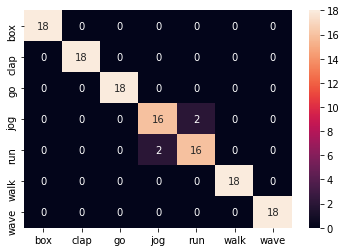

In [10]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# R(2+1)D Flow 92.86%

In [109]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_32x2x1_180e_kinetics400_rgb/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth \
      -O checkpoints/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth

--2021-03-29 22:00:52--  https://download.openmmlab.com/mmaction/recognition/r2plus1d/r2plus1d_r34_32x2x1_180e_kinetics400_rgb/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255319372 (243M) [application/octet-stream]
Saving to: ‘checkpoints/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth’

checkpoints/r2plus1 100%[===================>] 243,49M  5,15MB/s    in 44s     

2021-03-29 22:01:39 (5,58 MB/s) - ‘checkpoints/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth’ saved [255319372/255319372]



In [2]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/r2plus1d/r2plus1d_r34_32x2x1_180e_kinetics400_rgb.py')

In [3]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-R2+1D-flow'

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


cfg.val_pipeline = [
    dict(type='SampleFrames',clip_len=32, frame_interval=2, num_clips=1, test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
#     dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5)
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.test_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=10, test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='ThreeCrop', crop_size=256),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]

cfg.train_pipeline = [
    dict(type='SampleFrames', clip_len=32, frame_interval=2, num_clips=1),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
#     dict(type='RandomCrop', size=224),
    dict(type='RandomResizedCrop'),
    dict(type='Resize', scale=(224, 224), keep_ratio=False),
#     dict(type='Flip', flip_ratio=0.5),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

test_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=32,
        frame_interval=2,
        num_clips=10,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='ThreeCrop', crop_size=256),
    dict(type='Flip', flip_ratio=0),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_bgr=False),
    dict(type='FormatShape', input_format='NCTHW'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline


cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.data.videos_per_gpu=8

cfg.model.backbone.in_channels = 2

del cfg.model.backbone['norm_cfg']

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet2Plus1d',
        depth=34,
        pretrained=None,
        pretrained2d=False,
        norm_eval=False,
        conv_cfg=dict(type='Conv2plus1d'),
        conv1_kernel=(3, 7, 7),
        conv1_stride_t=1,
        pool1_stride_t=1,
        inflate=(1, 1, 1, 1),
        spatial_strides=(1, 2, 2, 2),
        temporal_strides=(1, 2, 2, 2),
        zero_init_residual=False,
        in_channels=2),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=512,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
checkpoint_config = dict(interval=12)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook')])
dist_params = dict(backend='nccl')
log_level = 'INFO'
load_from = 'checkpoints/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth'
resume_from = None
workflow = [('tr

In [15]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-31 09:23:45,313 - mmaction - INFO - load checkpoint from checkpoints/r2plus1d_r34_32x2x1_180e_kinetics400_rgb_20200618-63462eb3.pth
2021-03-31 09:23:45,314 - mmaction - INFO - Use load_from_local loader
2021-03-31 09:23:45,882 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for backbone.conv1.conv.conv_s.weight: copying a param with shape torch.Size([83, 3, 1, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 1, 7, 7]).
size mismatch for backbone.conv1.conv.bn_s.weight: copying a param with shape torch.Size([83]) from checkpoint, the shape in current model is torch.Size([64]).
size mismatch for backbone.conv1.conv.bn_s.bias: copying a param with shape torch.Size([83]) from checkpoint, the shape in current model is torch.Size([64]).
size mismatch for backbone.conv1.conv.bn_s.running_mean: copying a param with shape torch.Size([83]) from checkpoint, the shape in current model is torch.Size([64]).
size mismatch for 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.5 task/s, elapsed: 6s, ETA:     0s

2021-03-31 09:38:15,316 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 09:38:15,318 - mmaction - INFO - 
top1_acc	0.5714
top5_acc	0.9762
2021-03-31 09:38:15,319 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 09:38:15,321 - mmaction - INFO - 
mean_acc	0.5714
2021-03-31 09:38:16,193 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-31 09:38:16,194 - mmaction - INFO - Best top1_acc is 0.5714 at 5 epoch.
2021-03-31 09:38:16,195 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.5714, top5_acc: 0.9762, mean_class_accuracy: 0.5714
2021-03-31 09:40:28,170 - mmaction - INFO - Epoch [6][100/132]	lr: 1.990e-01, eta: 1:43:40, time: 1.320, data_time: 0.029, memory: 21787, top1_acc: 0.3650, top5_acc: 0.9375, loss_cls: 1.5938, loss: 1.5938, grad_norm: 1.1622
2021-03-31 09:43:21,009 - mmaction - INFO - Epoch [7][100/132]	lr: 2.416e-01, eta: 1:40:49, time: 1.323, data_time: 0.030, memory: 21787, top1_acc: 0.4462, top5_acc: 0.9563, 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.1 task/s, elapsed: 7s, ETA:     0s

2021-03-31 09:52:47,838 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 09:52:47,839 - mmaction - INFO - 
top1_acc	0.3889
top5_acc	0.9762
2021-03-31 09:52:47,839 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 09:52:47,840 - mmaction - INFO - 
mean_acc	0.3889
2021-03-31 09:52:47,841 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.3889, top5_acc: 0.9762, mean_class_accuracy: 0.3889
2021-03-31 09:55:00,419 - mmaction - INFO - Epoch [11][100/132]	lr: 4.412e-01, eta: 1:30:39, time: 1.326, data_time: 0.032, memory: 21787, top1_acc: 0.4100, top5_acc: 0.9300, loss_cls: 1.5292, loss: 1.5292, grad_norm: 1.0860
2021-03-31 09:57:53,570 - mmaction - INFO - Epoch [12][100/132]	lr: 4.925e-01, eta: 1:28:15, time: 1.325, data_time: 0.030, memory: 21787, top1_acc: 0.3912, top5_acc: 0.9125, loss_cls: 1.6177, loss: 1.6177, grad_norm: 1.0584
2021-03-31 09:58:34,518 - mmaction - INFO - Saving checkpoint at 12 epochs
2021-03-31 10:00:49,321 - mmaction - INFO - Epoch [13][

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.7 task/s, elapsed: 7s, ETA:     0s

2021-03-31 10:07:22,687 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 10:07:22,690 - mmaction - INFO - 
top1_acc	0.3810
top5_acc	0.9921
2021-03-31 10:07:22,690 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 10:07:22,692 - mmaction - INFO - 
mean_acc	0.3810
2021-03-31 10:07:22,692 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.3810, top5_acc: 0.9921, mean_class_accuracy: 0.3810
2021-03-31 10:09:35,099 - mmaction - INFO - Epoch [16][100/132]	lr: 6.673e-01, eta: 1:18:55, time: 1.324, data_time: 0.031, memory: 21787, top1_acc: 0.4200, top5_acc: 0.9200, loss_cls: 1.4761, loss: 1.4761, grad_norm: 0.7987
2021-03-31 10:12:28,037 - mmaction - INFO - Epoch [17][100/132]	lr: 6.982e-01, eta: 1:16:36, time: 1.323, data_time: 0.030, memory: 21787, top1_acc: 0.3962, top5_acc: 0.9275, loss_cls: 1.5405, loss: 1.5405, grad_norm: 0.8146
2021-03-31 10:15:20,955 - mmaction - INFO - Epoch [18][100/132]	lr: 7.224e-01, eta: 1:14:18, time: 1.323, data_time: 0.030, memory

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.0 task/s, elapsed: 7s, ETA:     0s

2021-03-31 10:21:53,861 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 10:21:53,863 - mmaction - INFO - 
top1_acc	0.5397
top5_acc	0.9603
2021-03-31 10:21:53,864 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 10:21:53,866 - mmaction - INFO - 
mean_acc	0.5397
2021-03-31 10:21:53,867 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.5397, top5_acc: 0.9603, mean_class_accuracy: 0.5397
2021-03-31 10:24:06,925 - mmaction - INFO - Epoch [21][100/132]	lr: 7.497e-01, eta: 1:07:29, time: 1.331, data_time: 0.030, memory: 21787, top1_acc: 0.4113, top5_acc: 0.9325, loss_cls: 1.5000, loss: 1.5000, grad_norm: 0.7922
2021-03-31 10:27:00,101 - mmaction - INFO - Epoch [22][100/132]	lr: 7.464e-01, eta: 1:05:13, time: 1.324, data_time: 0.029, memory: 21787, top1_acc: 0.3438, top5_acc: 0.8950, loss_cls: 1.6101, loss: 1.6101, grad_norm: 0.7219
2021-03-31 10:29:53,382 - mmaction - INFO - Epoch [23][100/132]	lr: 7.391e-01, eta: 1:02:58, time: 1.326, data_time: 0.030, memory

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.9 task/s, elapsed: 7s, ETA:     0s

2021-03-31 10:36:28,322 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 10:36:28,324 - mmaction - INFO - 
top1_acc	0.2778
top5_acc	0.9841
2021-03-31 10:36:28,324 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 10:36:28,326 - mmaction - INFO - 
mean_acc	0.2778
2021-03-31 10:36:28,326 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.2778, top5_acc: 0.9841, mean_class_accuracy: 0.2778
2021-03-31 10:38:40,852 - mmaction - INFO - Epoch [26][100/132]	lr: 6.947e-01, eta: 0:56:13, time: 1.325, data_time: 0.029, memory: 21787, top1_acc: 0.4338, top5_acc: 0.9250, loss_cls: 1.5131, loss: 1.5131, grad_norm: 0.7067
2021-03-31 10:41:34,185 - mmaction - INFO - Epoch [27][100/132]	lr: 6.730e-01, eta: 0:53:58, time: 1.326, data_time: 0.031, memory: 21787, top1_acc: 0.3688, top5_acc: 0.9137, loss_cls: 1.5175, loss: 1.5175, grad_norm: 0.7141
2021-03-31 10:44:27,300 - mmaction - INFO - Epoch [28][100/132]	lr: 6.481e-01, eta: 0:51:44, time: 1.323, data_time: 0.029, memory

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.9 task/s, elapsed: 7s, ETA:     0s

2021-03-31 10:51:00,968 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 10:51:00,970 - mmaction - INFO - 
top1_acc	0.5159
top5_acc	0.9921
2021-03-31 10:51:00,971 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 10:51:00,973 - mmaction - INFO - 
mean_acc	0.5159
2021-03-31 10:51:00,973 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.5159, top5_acc: 0.9921, mean_class_accuracy: 0.5159
2021-03-31 10:53:13,569 - mmaction - INFO - Epoch [31][100/132]	lr: 5.573e-01, eta: 0:45:01, time: 1.326, data_time: 0.032, memory: 21787, top1_acc: 0.4288, top5_acc: 0.9287, loss_cls: 1.4670, loss: 1.4670, grad_norm: 0.7006
2021-03-31 10:56:06,702 - mmaction - INFO - Epoch [32][100/132]	lr: 5.228e-01, eta: 0:42:47, time: 1.325, data_time: 0.029, memory: 21787, top1_acc: 0.4750, top5_acc: 0.9387, loss_cls: 1.2957, loss: 1.2957, grad_norm: 0.7049
2021-03-31 10:59:01,048 - mmaction - INFO - Epoch [33][100/132]	lr: 4.867e-01, eta: 0:40:34, time: 1.337, data_time: 0.029, memory

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.8 task/s, elapsed: 7s, ETA:     0s

2021-03-31 11:05:33,816 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 11:05:33,818 - mmaction - INFO - 
top1_acc	0.4841
top5_acc	0.9921
2021-03-31 11:05:33,819 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 11:05:33,822 - mmaction - INFO - 
mean_acc	0.4841
2021-03-31 11:05:33,823 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.4841, top5_acc: 0.9921, mean_class_accuracy: 0.4841
2021-03-31 11:07:45,972 - mmaction - INFO - Epoch [36][100/132]	lr: 3.730e-01, eta: 0:33:52, time: 1.321, data_time: 0.029, memory: 21787, top1_acc: 0.4612, top5_acc: 0.9437, loss_cls: 1.3194, loss: 1.3194, grad_norm: 0.6193
2021-03-31 11:08:26,439 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-03-31 11:10:39,603 - mmaction - INFO - Epoch [37][100/132]	lr: 3.345e-01, eta: 0:31:38, time: 1.323, data_time: 0.030, memory: 21787, top1_acc: 0.5262, top5_acc: 0.9300, loss_cls: 1.1870, loss: 1.1870, grad_norm: 0.6579
2021-03-31 11:13:32,371 - mmaction - INFO - Epoch [38][

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.0 task/s, elapsed: 7s, ETA:     0s

2021-03-31 11:20:05,134 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 11:20:05,136 - mmaction - INFO - 
top1_acc	0.7540
top5_acc	1.0000
2021-03-31 11:20:05,136 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 11:20:05,138 - mmaction - INFO - 
mean_acc	0.7540
2021-03-31 11:20:06,021 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-31 11:20:06,022 - mmaction - INFO - Best top1_acc is 0.7540 at 40 epoch.
2021-03-31 11:20:06,023 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.7540, top5_acc: 1.0000, mean_class_accuracy: 0.7540
2021-03-31 11:22:18,278 - mmaction - INFO - Epoch [41][100/132]	lr: 1.891e-01, eta: 0:22:44, time: 1.323, data_time: 0.031, memory: 21787, top1_acc: 0.5750, top5_acc: 0.9575, loss_cls: 1.0494, loss: 1.0494, grad_norm: 0.6308
2021-03-31 11:25:10,980 - mmaction - INFO - Epoch [42][100/132]	lr: 1.567e-01, eta: 0:20:30, time: 1.321, data_time: 0.031, memory: 21787, top1_acc: 0.5575, top5_acc: 0.9

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.1 task/s, elapsed: 7s, ETA:     0s

2021-03-31 11:34:39,377 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 11:34:39,378 - mmaction - INFO - 
top1_acc	0.7381
top5_acc	0.9921
2021-03-31 11:34:39,379 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 11:34:39,379 - mmaction - INFO - 
mean_acc	0.7381
2021-03-31 11:34:39,380 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.7381, top5_acc: 0.9921, mean_class_accuracy: 0.7381
2021-03-31 11:36:51,694 - mmaction - INFO - Epoch [46][100/132]	lr: 5.315e-02, eta: 0:11:37, time: 1.323, data_time: 0.032, memory: 21787, top1_acc: 0.5800, top5_acc: 0.9725, loss_cls: 1.0079, loss: 1.0079, grad_norm: 0.6084
2021-03-31 11:39:44,512 - mmaction - INFO - Epoch [47][100/132]	lr: 3.512e-02, eta: 0:09:24, time: 1.322, data_time: 0.031, memory: 21787, top1_acc: 0.6138, top5_acc: 0.9537, loss_cls: 0.9614, loss: 0.9614, grad_norm: 0.5681
2021-03-31 11:42:37,390 - mmaction - INFO - Epoch [48][100/132]	lr: 2.067e-02, eta: 0:07:11, time: 1.323, data_time: 0.032, memory

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.5 task/s, elapsed: 6s, ETA:     0s

2021-03-31 11:49:11,545 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-31 11:49:11,547 - mmaction - INFO - 
top1_acc	0.8016
top5_acc	0.9921
2021-03-31 11:49:11,548 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-31 11:49:11,550 - mmaction - INFO - 
mean_acc	0.8016
2021-03-31 11:49:12,507 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_50.pth.
2021-03-31 11:49:12,508 - mmaction - INFO - Best top1_acc is 0.8016 at 50 epoch.
2021-03-31 11:49:12,508 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.8016, top5_acc: 0.9921, mean_class_accuracy: 0.8016
2021-03-31 11:51:24,614 - mmaction - INFO - Epoch [51][100/132]	lr: 1.242e-04, eta: 0:00:32, time: 1.321, data_time: 0.030, memory: 21787, top1_acc: 0.5988, top5_acc: 0.9537, loss_cls: 0.9938, loss: 0.9938, grad_norm: 0.6841


In [16]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [4]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

In [5]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=1,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.6 task/s, elapsed: 210s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9286
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9286
top1_acc: 0.9286
top5_acc: 1.0000
mean_class_accuracy: 0.9286


<AxesSubplot:>

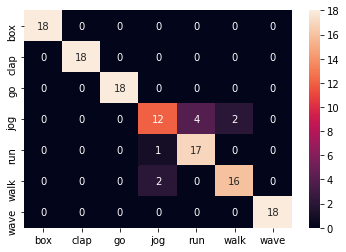

In [6]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# TIN 87.30%

In [8]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/tin/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth \
      -O checkpoints/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth

--2021-03-29 22:59:27--  https://download.openmmlab.com/mmaction/recognition/tin/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.75.20.25
Connecting to download.openmmlab.com (download.openmmlab.com)|47.75.20.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97729017 (93M) [application/octet-stream]
Saving to: ‘checkpoints/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth’

checkpoints/tin_tsm 100%[===================>]  93,20M  8,39MB/s    in 13s     

2021-03-29 22:59:44 (7,23 MB/s) - ‘checkpoints/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth’ saved [97729017/97729017]



In [44]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/tin/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb.py')

In [45]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rawframe/train/'
cfg.data_root_val = 'data/childact_rawframe/val/'
cfg.ann_file_train = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.ann_file_val = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.ann_file_test = 'data/childact_rawframe/childact_test_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rawframe/childact_test_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rawframe/childact_train_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rawframe/childact_val_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rawframe/val/'

cfg.data.test.modality = 'Flow'
cfg.data.val.modality = 'Flow'
cfg.data.train.modality = 'Flow'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-TIN'

cfg.img_norm_cfg = dict(mean=[128, 128], std=[128, 128])


cfg.val_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=1,
        frame_interval=1,
        num_clips=8,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
    dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCHW_Flow'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.test_pipeline = [
    dict(
        type='SampleFrames',
        clip_len=1,
        frame_interval=1,
        num_clips=8,
        test_mode=True),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
     dict(type='CenterCrop', crop_size=224),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCHW_Flow'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs'])
]
cfg.train_pipeline = [
    dict(type='SampleFrames', clip_len=1, frame_interval=1, num_clips=8),
    dict(type='RawFrameDecode'),
    dict(type='Resize', scale=(-1, 256)),
#     dict(type='RandomCrop', size=224),
    dict(
        type='MultiScaleCrop',
        input_size=224,
        scales=(1, 0.875, 0.75, 0.66),
        random_crop=False,
        max_wh_scale_gap=1),
    dict(type='Resize', scale=(224, 224), keep_ratio=False),
    dict(type='Normalize', mean=[128, 128], std=[128, 128]),
    dict(type='FormatShape', input_format='NCHW_Flow'),
    dict(type='Collect', keys=['imgs', 'label'], meta_keys=[]),
    dict(type='ToTensor', keys=['imgs', 'label'])
]

cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.val.pipeline = cfg.val_pipeline
cfg.data.test.pipeline = cfg.test_pipeline

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer2D',
    backbone=dict(
        type='ResNetTIN',
        pretrained='torchvision://resnet50',
        depth=50,
        norm_eval=False,
        shift_div=4,
        in_channels=2),
    cls_head=dict(
        type='TSMHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        consensus=dict(type='AvgConsensus', dim=1),
        dropout_ratio=0.5,
        init_std=0.001,
        is_shift=True),
    train_cfg=None,
    test_cfg=dict(average_clips=None))
optimizer = dict(
    type='SGD',
    lr=0.01,
    momentum=0.9,
    weight_decay=0.0001,
    constructor='TSMOptimizerConstructor',
    paramwise_cfg=dict(fc_lr5=True))
optimizer_config = dict(grad_clip=dict(max_norm=20, norm_type=2))
lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-05),
    cyclic_times=1,
    step_ratio_up=0.4)
total_epochs = 51
checkpoint_config = dict(interval=12)
log_config = dict(interval=100, hooks=[dict(type='TextLoggerHook'

In [41]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-03-29 23:41:40,330 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias', 'conv1.weight'}


Use load_from_torchvision loader


2021-03-29 23:41:40,412 - mmaction - INFO - load checkpoint from checkpoints/tin_tsm_finetune_r50_1x1x8_50e_kinetics400_rgb_20200810-4a146a70.pth
2021-03-29 23:41:40,414 - mmaction - INFO - Use load_from_local loader
2021-03-29 23:41:40,506 - mmaction - WARNING - The model and loaded state dict do not match exactly

size mismatch for backbone.conv1.conv.weight: copying a param with shape torch.Size([64, 3, 7, 7]) from checkpoint, the shape in current model is torch.Size([64, 2, 7, 7]).
size mismatch for cls_head.fc_cls.weight: copying a param with shape torch.Size([400, 2048]) from checkpoint, the shape in current model is torch.Size([7, 2048]).
size mismatch for cls_head.fc_cls.bias: copying a param with shape torch.Size([400]) from checkpoint, the shape in current model is torch.Size([7]).
2021-03-29 23:41:40,508 - mmaction - INFO - Start running, host: actrec@actrec-HP-Z4-G4-Workstation, work_dir: /home/actrec/.virtualenvs/mmaction/mmaction2/childact-checkpoints/childact-TIN
2021-03

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 60.5 task/s, elapsed: 2s, ETA:     0s

2021-03-29 23:46:00,366 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 23:46:00,368 - mmaction - INFO - 
top1_acc	0.6984
top5_acc	0.9921
2021-03-29 23:46:00,369 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 23:46:00,370 - mmaction - INFO - 
mean_acc	0.6984
2021-03-29 23:46:00,647 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-03-29 23:46:00,648 - mmaction - INFO - Best top1_acc is 0.6984 at 5 epoch.
2021-03-29 23:46:00,649 - mmaction - INFO - Epoch(val) [5][175]	top1_acc: 0.6984, top5_acc: 0.9921, mean_class_accuracy: 0.6984
2021-03-29 23:46:31,401 - mmaction - INFO - Epoch [6][100/175]	lr: 2.554e-02, eta: 0:24:49, time: 0.307, data_time: 0.024, memory: 6231, top1_acc: 0.6183, top5_acc: 0.9883, loss_cls: 1.0457, loss: 1.0457, grad_norm: 3.3395
2021-03-29 23:47:23,205 - mmaction - INFO - Epoch [7][100/175]	lr: 3.111e-02, eta: 0:24:01, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.5883, top5_acc: 0.9767, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 62.1 task/s, elapsed: 2s, ETA:     0s

2021-03-29 23:50:22,056 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 23:50:22,058 - mmaction - INFO - 
top1_acc	0.7143
top5_acc	1.0000
2021-03-29 23:50:22,059 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 23:50:22,061 - mmaction - INFO - 
mean_acc	0.7143
2021-03-29 23:50:22,344 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-03-29 23:50:22,345 - mmaction - INFO - Best top1_acc is 0.7143 at 10 epoch.
2021-03-29 23:50:22,346 - mmaction - INFO - Epoch(val) [10][175]	top1_acc: 0.7143, top5_acc: 1.0000, mean_class_accuracy: 0.7143
2021-03-29 23:50:52,920 - mmaction - INFO - Epoch [11][100/175]	lr: 5.753e-02, eta: 0:21:23, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.6600, top5_acc: 0.9900, loss_cls: 0.9106, loss: 0.9106, grad_norm: 2.1179
2021-03-29 23:51:44,676 - mmaction - INFO - Epoch [12][100/175]	lr: 6.439e-02, eta: 0:20:47, time: 0.305, data_time: 0.024, memory: 6231, top1_acc: 0.6900, top5_acc: 0.990

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 61.8 task/s, elapsed: 2s, ETA:     0s

2021-03-29 23:54:43,532 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 23:54:43,534 - mmaction - INFO - 
top1_acc	0.7698
top5_acc	1.0000
2021-03-29 23:54:43,535 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 23:54:43,536 - mmaction - INFO - 
mean_acc	0.7698
2021-03-29 23:54:43,844 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-03-29 23:54:43,845 - mmaction - INFO - Best top1_acc is 0.7698 at 15 epoch.
2021-03-29 23:54:43,846 - mmaction - INFO - Epoch(val) [15][175]	top1_acc: 0.7698, top5_acc: 1.0000, mean_class_accuracy: 0.7698
2021-03-29 23:55:15,191 - mmaction - INFO - Epoch [16][100/175]	lr: 8.809e-02, eta: 0:18:32, time: 0.313, data_time: 0.024, memory: 6231, top1_acc: 0.7067, top5_acc: 0.9933, loss_cls: 0.7561, loss: 0.7561, grad_norm: 1.5346
2021-03-29 23:56:06,946 - mmaction - INFO - Epoch [17][100/175]	lr: 9.238e-02, eta: 0:17:59, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.7033, top5_acc: 0.978

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 62.1 task/s, elapsed: 2s, ETA:     0s

2021-03-29 23:59:05,631 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-29 23:59:05,632 - mmaction - INFO - 
top1_acc	0.7460
top5_acc	0.9921
2021-03-29 23:59:05,632 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-29 23:59:05,633 - mmaction - INFO - 
mean_acc	0.7460
2021-03-29 23:59:05,634 - mmaction - INFO - Epoch(val) [20][175]	top1_acc: 0.7460, top5_acc: 0.9921, mean_class_accuracy: 0.7460
2021-03-29 23:59:36,248 - mmaction - INFO - Epoch [21][100/175]	lr: 9.999e-02, eta: 0:15:49, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.7350, top5_acc: 0.9950, loss_cls: 0.6835, loss: 0.6835, grad_norm: 1.3199
2021-03-30 00:00:28,007 - mmaction - INFO - Epoch [22][100/175]	lr: 9.964e-02, eta: 0:15:17, time: 0.306, data_time: 0.023, memory: 6231, top1_acc: 0.7100, top5_acc: 0.9933, loss_cls: 0.7411, loss: 0.7411, grad_norm: 1.3525
2021-03-30 00:01:19,817 - mmaction - INFO - Epoch [23][100/175]	lr: 9.877e-02, eta: 0:14:45, time: 0.306, data_time: 0.024, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 61.6 task/s, elapsed: 2s, ETA:     0s

2021-03-30 00:03:26,696 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-30 00:03:26,698 - mmaction - INFO - 
top1_acc	0.7302
top5_acc	1.0000
2021-03-30 00:03:26,699 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-30 00:03:26,700 - mmaction - INFO - 
mean_acc	0.7302
2021-03-30 00:03:26,701 - mmaction - INFO - Epoch(val) [25][175]	top1_acc: 0.7302, top5_acc: 1.0000, mean_class_accuracy: 0.7302
2021-03-30 00:03:57,272 - mmaction - INFO - Epoch [26][100/175]	lr: 9.313e-02, eta: 0:13:10, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.7050, top5_acc: 0.9833, loss_cls: 0.6978, loss: 0.6978, grad_norm: 1.1034
2021-03-30 00:04:49,048 - mmaction - INFO - Epoch [27][100/175]	lr: 9.031e-02, eta: 0:12:38, time: 0.305, data_time: 0.024, memory: 6231, top1_acc: 0.7567, top5_acc: 0.9967, loss_cls: 0.6220, loss: 0.6220, grad_norm: 1.1670
2021-03-30 00:05:40,725 - mmaction - INFO - Epoch [28][100/175]	lr: 8.707e-02, eta: 0:12:07, time: 0.306, data_time: 0.024, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 62.0 task/s, elapsed: 2s, ETA:     0s

2021-03-30 00:07:47,561 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-30 00:07:47,563 - mmaction - INFO - 
top1_acc	0.7857
top5_acc	1.0000
2021-03-30 00:07:47,563 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-30 00:07:47,565 - mmaction - INFO - 
mean_acc	0.7857
2021-03-30 00:07:47,859 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_30.pth.
2021-03-30 00:07:47,860 - mmaction - INFO - Best top1_acc is 0.7857 at 30 epoch.
2021-03-30 00:07:47,861 - mmaction - INFO - Epoch(val) [30][175]	top1_acc: 0.7857, top5_acc: 1.0000, mean_class_accuracy: 0.7857
2021-03-30 00:08:18,542 - mmaction - INFO - Epoch [31][100/175]	lr: 7.515e-02, eta: 0:10:33, time: 0.307, data_time: 0.024, memory: 6231, top1_acc: 0.7867, top5_acc: 0.9967, loss_cls: 0.5664, loss: 0.5664, grad_norm: 1.0673
2021-03-30 00:09:11,145 - mmaction - INFO - Epoch [32][100/175]	lr: 7.059e-02, eta: 0:10:02, time: 0.308, data_time: 0.024, memory: 6231, top1_acc: 0.7950, top5_acc: 0.995

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 61.6 task/s, elapsed: 2s, ETA:     0s

2021-03-30 00:12:10,560 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-30 00:12:10,562 - mmaction - INFO - 
top1_acc	0.7778
top5_acc	1.0000
2021-03-30 00:12:10,563 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-30 00:12:10,565 - mmaction - INFO - 
mean_acc	0.7778
2021-03-30 00:12:10,567 - mmaction - INFO - Epoch(val) [35][175]	top1_acc: 0.7778, top5_acc: 1.0000, mean_class_accuracy: 0.7778
2021-03-30 00:12:41,260 - mmaction - INFO - Epoch [36][100/175]	lr: 5.069e-02, eta: 0:07:57, time: 0.307, data_time: 0.024, memory: 6231, top1_acc: 0.8067, top5_acc: 0.9967, loss_cls: 0.5010, loss: 0.5010, grad_norm: 1.1623
2021-03-30 00:13:02,501 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-03-30 00:13:33,496 - mmaction - INFO - Epoch [37][100/175]	lr: 4.556e-02, eta: 0:07:26, time: 0.307, data_time: 0.024, memory: 6231, top1_acc: 0.7933, top5_acc: 0.9950, loss_cls: 0.5430, loss: 0.5430, grad_norm: 1.1383
2021-03-30 00:14:25,353 - mmaction - INFO - Epoch [38][10

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 60.8 task/s, elapsed: 2s, ETA:     0s

2021-03-30 00:16:32,542 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-30 00:16:32,545 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-03-30 00:16:32,545 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-30 00:16:32,547 - mmaction - INFO - 
mean_acc	0.8095
2021-03-30 00:16:32,849 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-03-30 00:16:32,850 - mmaction - INFO - Best top1_acc is 0.8095 at 40 epoch.
2021-03-30 00:16:32,850 - mmaction - INFO - Epoch(val) [40][175]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-03-30 00:17:03,513 - mmaction - INFO - Epoch [41][100/175]	lr: 2.605e-02, eta: 0:05:22, time: 0.307, data_time: 0.024, memory: 6231, top1_acc: 0.8267, top5_acc: 0.9933, loss_cls: 0.4550, loss: 0.4550, grad_norm: 1.0917
2021-03-30 00:17:55,331 - mmaction - INFO - Epoch [42][100/175]	lr: 2.168e-02, eta: 0:04:51, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.7883, top5_acc: 0.995

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 59.8 task/s, elapsed: 2s, ETA:     0s

2021-03-30 00:20:54,118 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-30 00:20:54,120 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-03-30 00:20:54,121 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-30 00:20:54,122 - mmaction - INFO - 
mean_acc	0.8095
2021-03-30 00:20:54,123 - mmaction - INFO - Epoch(val) [45][175]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-03-30 00:21:24,717 - mmaction - INFO - Epoch [46][100/175]	lr: 7.582e-03, eta: 0:02:47, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.8467, top5_acc: 0.9917, loss_cls: 0.3691, loss: 0.3691, grad_norm: 0.9940
2021-03-30 00:22:16,425 - mmaction - INFO - Epoch [47][100/175]	lr: 5.093e-03, eta: 0:02:16, time: 0.306, data_time: 0.024, memory: 6231, top1_acc: 0.8383, top5_acc: 0.9967, loss_cls: 0.3614, loss: 0.3614, grad_norm: 0.9574
2021-03-30 00:23:08,294 - mmaction - INFO - Epoch [48][100/175]	lr: 3.076e-03, eta: 0:01:45, time: 0.306, data_time: 0.024, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 63.3 task/s, elapsed: 2s, ETA:     0s

2021-03-30 00:25:15,442 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-03-30 00:25:15,444 - mmaction - INFO - 
top1_acc	0.8095
top5_acc	1.0000
2021-03-30 00:25:15,445 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-03-30 00:25:15,448 - mmaction - INFO - 
mean_acc	0.8095
2021-03-30 00:25:15,449 - mmaction - INFO - Epoch(val) [50][175]	top1_acc: 0.8095, top5_acc: 1.0000, mean_class_accuracy: 0.8095
2021-03-30 00:25:46,192 - mmaction - INFO - Epoch [51][100/175]	lr: 4.979e-05, eta: 0:00:13, time: 0.307, data_time: 0.024, memory: 6231, top1_acc: 0.8217, top5_acc: 0.9950, loss_cls: 0.3936, loss: 0.3936, grad_norm: 1.1156


In [42]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [46]:
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

2021-03-30 01:00:17,769 - mmaction - INFO - These parameters in pretrained checkpoint are not loaded: {'fc.weight', 'fc.bias', 'conv1.weight'}


Use load_from_torchvision loader


In [47]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=4,
        workers_per_gpu=1,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 59.5 task/s, elapsed: 2s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.8730
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.8730
top1_acc: 0.8730
top5_acc: 1.0000
mean_class_accuracy: 0.8730


<AxesSubplot:>

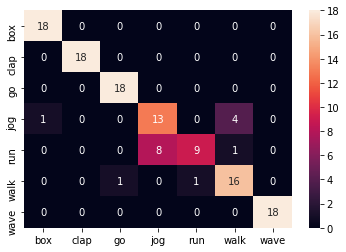

In [48]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )

# I3D 96.83%

In [1]:
# !mkdir checkpoints
!wget -c https://download.openmmlab.com/mmaction/recognition/i3d/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb_20200813-6e6aef1b.pth \
      -O checkpoints/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb_20200813-6e6aef1b.pth

--2021-04-01 15:05:30--  https://download.openmmlab.com/mmaction/recognition/i3d/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb_20200813-6e6aef1b.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.254.186.225
Connecting to download.openmmlab.com (download.openmmlab.com)|47.254.186.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141906964 (135M) [application/octet-stream]
Saving to: ‘checkpoints/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb_20200813-6e6aef1b.pth’

checkpoints/i3d_nl_ 100%[===================>] 135,33M  8,89MB/s    in 15s     

2021-04-01 15:05:46 (8,92 MB/s) - ‘checkpoints/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb_20200813-6e6aef1b.pth’ saved [141906964/141906964]



In [1]:
from mmcv import Config
cfg = Config.fromfile('./configs/recognition/i3d/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb.py')
# print(f'Config:\n{cfg.pretty_text}')

In [2]:
from mmcv.runner import set_random_seed

# Modify dataset type and path
# cfg.dataset_type = 'VideoDataset'
cfg.data_root = 'data/childact_rgb_rawframe/train/'
cfg.data_root_val = 'data/childact_rgb_rawframe/val/'
cfg.ann_file_train = 'data/childact_rgb_rawframe/childact_train_rgb_rawframe.txt'
cfg.ann_file_val = 'data/childact_rgb_rawframe/childact_val_rgb_rawframe.txt'
cfg.ann_file_test = 'data/childact_rgb_rawframe/childact_test_rgb_rawframe.txt'

# cfg.data.test.type = 'VideoDataset'
cfg.data.test.ann_file = 'data/childact_rgb_rawframe/childact_test_rgb_rawframe.txt'
cfg.data.test.data_prefix = 'data/childact_rgb_rawframe/test/'

# cfg.data.train.type = 'VideoDataset'
cfg.data.train.ann_file = 'data/childact_rgb_rawframe/childact_train_rgb_rawframe.txt'
cfg.data.train.data_prefix = 'data/childact_rgb_rawframe/train/'

# cfg.data.val.type = 'VideoDataset'
cfg.data.val.ann_file = 'data/childact_rgb_rawframe/childact_val_rgb_rawframe.txt'
cfg.data.val.data_prefix = 'data/childact_rgb_rawframe/val/'

cfg.data.train.start_index = 0
cfg.data.test.start_index = 0
cfg.data.val.start_index = 0

# cfg.data.test.filename_tmpl = 'flow_{}_{:05d}.jpg'
# cfg.data.train.filename_tmpl = 'flow_{}_{:05d}.jpg'
# cfg.data.val.filename_tmpl = 'flow_{}_{:05d}.jpg'
# The flag is used to determine whether it is omnisource training
cfg.setdefault('omnisource', False)
# Modify num classes of the model in cls_head
cfg.model.cls_head.num_classes = 7
# We can use the pre-trained TSN model
cfg.load_from = 'checkpoints/i3d_nl_embedded_gaussian_r50_32x2x1_100e_kinetics400_rgb_20200813-6e6aef1b.pth'
# cfg.resume_from = './childact-mm/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './childact-checkpoints/childact-i3D'

cfg.lr_config = dict(
    policy='cyclic',
    target_ratio=(10, 1e-5),
    cyclic_times=1,
    step_ratio_up=0.4,
)

cfg.total_epochs = 51

cfg.momentum_config = dict(
    policy='cyclic',
    target_ratio=(0.85 / 0.95, 1),
    cyclic_times=1,
    step_ratio_up=0.4,
)

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12
# We can set the log print interval to reduce the the times of printing log
cfg.log_config.interval = 100

# Set seed thus the results are more reproducible
cfg.seed = 42
set_random_seed(42, deterministic=False)
cfg.gpu_ids = range(1)

# cfg.img_norm_cfg.mean = [0.485, 0.456, 0.406]
# cfg.img_norm_cfg.std = [0.229, 0.224, 0.225]

# cfg.train_pipeline[6] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
# cfg.test_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)
# cfg.val_pipeline[4] = dict(type='Normalize', mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], to_bgr=False)

# cfg.model.backbone.in_channels = 2

cfg.output_config = dict(out=f'{cfg.work_dir}/results.json')
# We can initialize the logger for training and have a look
# at the final config used for training
# del cfg.optimizer['momentum']
print(f'Config:\n{cfg.pretty_text}')

Config:
model = dict(
    type='Recognizer3D',
    backbone=dict(
        type='ResNet3d',
        pretrained2d=True,
        pretrained='torchvision://resnet50',
        depth=50,
        conv_cfg=dict(type='Conv3d'),
        norm_eval=False,
        inflate=((1, 1, 1), (1, 0, 1, 0), (1, 0, 1, 0, 1, 0), (0, 1, 0)),
        zero_init_residual=False,
        non_local=((0, 0, 0), (0, 1, 0, 1), (0, 1, 0, 1, 0, 1), (0, 0, 0)),
        non_local_cfg=dict(
            sub_sample=True,
            use_scale=False,
            norm_cfg=dict(type='BN3d', requires_grad=True),
            mode='embedded_gaussian')),
    cls_head=dict(
        type='I3DHead',
        num_classes=7,
        in_channels=2048,
        spatial_type='avg',
        dropout_ratio=0.5,
        init_std=0.01),
    train_cfg=None,
    test_cfg=dict(average_clips='prob'))
optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
optimizer_config = dict(grad_clip=dict(max_norm=40, norm_type=2))
lr_config = dic

In [3]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model

import mmcv

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# model = build_detector(cfg.model, train_cfg=cfg.train_cfg, test_cfg=cfg.test_cfg)

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_model(model, datasets, cfg, distributed=False, validate=True)

2021-04-01 15:07:37,615 - mmaction - INFO - load model from: torchvision://resnet50
2021-04-01 15:07:37,776 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.g.0
2021-04-01 15:07:37,777 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.g.0
2021-04-01 15:07:37,778 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.conv_out
2021-04-01 15:07:37,779 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.bn_out
2021-04-01 15:07:37,780 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.theta
2021-04-01 15:07:37,780 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.theta
2021-04-01 15:07:37,781 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.phi.0
2021-04-01 15:07:37,782 - mmaction - WARNING - Module not exist in the state_dict_r2d: lay

Use load_from_torchvision loader


2021-04-01 15:07:37,816 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.3.non_local_block.bn_out
2021-04-01 15:07:37,817 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.3.non_local_block.theta
2021-04-01 15:07:37,818 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.3.non_local_block.theta
2021-04-01 15:07:37,819 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.3.non_local_block.phi.0
2021-04-01 15:07:37,819 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.3.non_local_block.phi.0
2021-04-01 15:07:37,825 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.5.non_local_block.g.0
2021-04-01 15:07:37,826 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.5.non_local_block.g.0
2021-04-01 15:07:37,826 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.5.non_local_block.conv_out
2021-04-01 15:07:37,827 - mmaction - WARNING - Module no

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.8 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:13:00,389 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:13:00,391 - mmaction - INFO - 
top1_acc	0.7540
top5_acc	1.0000
2021-04-01 15:13:00,391 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:13:00,392 - mmaction - INFO - 
mean_acc	0.7540
2021-04-01 15:13:00,807 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_5.pth.
2021-04-01 15:13:00,808 - mmaction - INFO - Best top1_acc is 0.7540 at 5 epoch.
2021-04-01 15:13:00,809 - mmaction - INFO - Epoch(val) [5][132]	top1_acc: 0.7540, top5_acc: 1.0000, mean_class_accuracy: 0.7540
2021-04-01 15:13:45,525 - mmaction - INFO - Epoch [6][100/132]	lr: 2.653e-02, eta: 0:37:45, time: 0.447, data_time: 0.048, memory: 6295, top1_acc: 0.6475, top5_acc: 0.9862, loss_cls: 0.9266, loss: 0.9266, grad_norm: 4.3385
2021-04-01 15:14:43,072 - mmaction - INFO - Epoch [7][100/132]	lr: 3.221e-02, eta: 0:36:20, time: 0.447, data_time: 0.047, memory: 6295, top1_acc: 0.6787, top5_acc: 0.9900, lo

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.1 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:17:54,177 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:17:54,178 - mmaction - INFO - 
top1_acc	0.7857
top5_acc	1.0000
2021-04-01 15:17:54,179 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:17:54,179 - mmaction - INFO - 
mean_acc	0.7857
2021-04-01 15:17:54,613 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_10.pth.
2021-04-01 15:17:54,614 - mmaction - INFO - Best top1_acc is 0.7857 at 10 epoch.
2021-04-01 15:17:54,615 - mmaction - INFO - Epoch(val) [10][132]	top1_acc: 0.7857, top5_acc: 1.0000, mean_class_accuracy: 0.7857
2021-04-01 15:18:38,835 - mmaction - INFO - Epoch [11][100/132]	lr: 5.883e-02, eta: 0:31:52, time: 0.442, data_time: 0.045, memory: 6295, top1_acc: 0.7100, top5_acc: 0.9962, loss_cls: 0.7362, loss: 0.7362, grad_norm: 2.3710
2021-04-01 15:19:36,184 - mmaction - INFO - Epoch [12][100/132]	lr: 6.566e-02, eta: 0:30:55, time: 0.446, data_time: 0.044, memory: 6295, top1_acc: 0.6837, top5_acc: 0.987

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 19.0 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:22:48,508 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:22:48,510 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-04-01 15:22:48,511 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:22:48,513 - mmaction - INFO - 
mean_acc	0.8571
2021-04-01 15:22:49,027 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_15.pth.
2021-04-01 15:22:49,028 - mmaction - INFO - Best top1_acc is 0.8571 at 15 epoch.
2021-04-01 15:22:49,028 - mmaction - INFO - Epoch(val) [15][132]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-04-01 15:23:33,649 - mmaction - INFO - Epoch [16][100/132]	lr: 8.897e-02, eta: 0:27:23, time: 0.446, data_time: 0.046, memory: 6295, top1_acc: 0.7050, top5_acc: 0.9938, loss_cls: 0.7669, loss: 0.7669, grad_norm: 2.2776
2021-04-01 15:24:30,566 - mmaction - INFO - Epoch [17][100/132]	lr: 9.309e-02, eta: 0:26:32, time: 0.443, data_time: 0.042, memory: 6295, top1_acc: 0.7375, top5_acc: 0.993

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.9 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:27:44,700 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:27:44,703 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-04-01 15:27:44,704 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:27:44,706 - mmaction - INFO - 
mean_acc	0.8492
2021-04-01 15:27:44,707 - mmaction - INFO - Epoch(val) [20][132]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-04-01 15:28:29,267 - mmaction - INFO - Epoch [21][100/132]	lr: 9.997e-02, eta: 0:23:17, time: 0.446, data_time: 0.042, memory: 6295, top1_acc: 0.7400, top5_acc: 0.9950, loss_cls: 0.6544, loss: 0.6544, grad_norm: 1.6735
2021-04-01 15:29:26,443 - mmaction - INFO - Epoch [22][100/132]	lr: 9.952e-02, eta: 0:22:29, time: 0.445, data_time: 0.043, memory: 6295, top1_acc: 0.7300, top5_acc: 0.9962, loss_cls: 0.6228, loss: 0.6228, grad_norm: 1.5644
2021-04-01 15:30:23,664 - mmaction - INFO - Epoch [23][100/132]	lr: 9.854e-02, eta: 0:21:41, time: 0.444, data_time: 0.043, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.1 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:32:39,094 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:32:39,095 - mmaction - INFO - 
top1_acc	0.8571
top5_acc	1.0000
2021-04-01 15:32:39,096 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:32:39,096 - mmaction - INFO - 
mean_acc	0.8571
2021-04-01 15:32:39,097 - mmaction - INFO - Epoch(val) [25][132]	top1_acc: 0.8571, top5_acc: 1.0000, mean_class_accuracy: 0.8571
2021-04-01 15:33:24,216 - mmaction - INFO - Epoch [26][100/132]	lr: 9.263e-02, eta: 0:19:19, time: 0.451, data_time: 0.046, memory: 6295, top1_acc: 0.7550, top5_acc: 1.0000, loss_cls: 0.6145, loss: 0.6145, grad_norm: 1.5164
2021-04-01 15:34:21,486 - mmaction - INFO - Epoch [27][100/132]	lr: 8.973e-02, eta: 0:18:32, time: 0.446, data_time: 0.042, memory: 6295, top1_acc: 0.7725, top5_acc: 1.0000, loss_cls: 0.5407, loss: 0.5407, grad_norm: 1.4287
2021-04-01 15:35:18,922 - mmaction - INFO - Epoch [28][100/132]	lr: 8.641e-02, eta: 0:17:45, time: 0.448, data_time: 0.044, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.1 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:37:33,642 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:37:33,644 - mmaction - INFO - 
top1_acc	0.8492
top5_acc	1.0000
2021-04-01 15:37:33,645 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:37:33,647 - mmaction - INFO - 
mean_acc	0.8492
2021-04-01 15:37:33,648 - mmaction - INFO - Epoch(val) [30][132]	top1_acc: 0.8492, top5_acc: 1.0000, mean_class_accuracy: 0.8492
2021-04-01 15:38:18,224 - mmaction - INFO - Epoch [31][100/132]	lr: 7.431e-02, eta: 0:15:25, time: 0.446, data_time: 0.044, memory: 6295, top1_acc: 0.7750, top5_acc: 0.9962, loss_cls: 0.5964, loss: 0.5964, grad_norm: 1.4931
2021-04-01 15:39:15,493 - mmaction - INFO - Epoch [32][100/132]	lr: 6.971e-02, eta: 0:14:39, time: 0.447, data_time: 0.044, memory: 6295, top1_acc: 0.7788, top5_acc: 0.9950, loss_cls: 0.5383, loss: 0.5383, grad_norm: 1.3537
2021-04-01 15:40:13,266 - mmaction - INFO - Epoch [33][100/132]	lr: 6.490e-02, eta: 0:13:53, time: 0.449, data_time: 0.044, memory: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.4 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:42:27,760 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:42:27,762 - mmaction - INFO - 
top1_acc	0.8968
top5_acc	1.0000
2021-04-01 15:42:27,763 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:42:27,764 - mmaction - INFO - 
mean_acc	0.8968
2021-04-01 15:42:28,203 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_35.pth.
2021-04-01 15:42:28,204 - mmaction - INFO - Best top1_acc is 0.8968 at 35 epoch.
2021-04-01 15:42:28,205 - mmaction - INFO - Epoch(val) [35][132]	top1_acc: 0.8968, top5_acc: 1.0000, mean_class_accuracy: 0.8968
2021-04-01 15:43:12,791 - mmaction - INFO - Epoch [36][100/132]	lr: 4.973e-02, eta: 0:11:35, time: 0.446, data_time: 0.044, memory: 6295, top1_acc: 0.7963, top5_acc: 0.9962, loss_cls: 0.5294, loss: 0.5294, grad_norm: 1.3313
2021-04-01 15:43:25,427 - mmaction - INFO - Saving checkpoint at 36 epochs
2021-04-01 15:44:10,265 - mmaction - INFO - Epoch [37][100/132]	lr: 4.461e-02, eta: 0:10:48, tim

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.4 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:47:22,618 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:47:22,620 - mmaction - INFO - 
top1_acc	0.9048
top5_acc	1.0000
2021-04-01 15:47:22,620 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:47:22,622 - mmaction - INFO - 
mean_acc	0.9048
2021-04-01 15:47:23,062 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_40.pth.
2021-04-01 15:47:23,063 - mmaction - INFO - Best top1_acc is 0.9048 at 40 epoch.
2021-04-01 15:47:23,063 - mmaction - INFO - Epoch(val) [40][132]	top1_acc: 0.9048, top5_acc: 1.0000, mean_class_accuracy: 0.9048
2021-04-01 15:48:07,644 - mmaction - INFO - Epoch [41][100/132]	lr: 2.521e-02, eta: 0:07:45, time: 0.446, data_time: 0.042, memory: 6295, top1_acc: 0.8237, top5_acc: 1.0000, loss_cls: 0.4076, loss: 0.4076, grad_norm: 1.1360
2021-04-01 15:49:04,757 - mmaction - INFO - Epoch [42][100/132]	lr: 2.089e-02, eta: 0:07:00, time: 0.445, data_time: 0.041, memory: 6295, top1_acc: 0.8125, top5_acc: 0.997

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 18.2 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:52:16,493 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:52:16,494 - mmaction - INFO - 
top1_acc	0.9127
top5_acc	1.0000
2021-04-01 15:52:16,495 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:52:16,496 - mmaction - INFO - 
mean_acc	0.9127
2021-04-01 15:52:16,942 - mmaction - INFO - Now best checkpoint is saved as best_top1_acc_epoch_45.pth.
2021-04-01 15:52:16,943 - mmaction - INFO - Best top1_acc is 0.9127 at 45 epoch.
2021-04-01 15:52:16,944 - mmaction - INFO - Epoch(val) [45][132]	top1_acc: 0.9127, top5_acc: 1.0000, mean_class_accuracy: 0.9127
2021-04-01 15:53:01,439 - mmaction - INFO - Epoch [46][100/132]	lr: 7.086e-03, eta: 0:03:57, time: 0.445, data_time: 0.044, memory: 6295, top1_acc: 0.8225, top5_acc: 0.9975, loss_cls: 0.4624, loss: 0.4624, grad_norm: 1.2670
2021-04-01 15:54:00,925 - mmaction - INFO - Epoch [47][100/132]	lr: 4.683e-03, eta: 0:03:12, time: 0.468, data_time: 0.052, memory: 6295, top1_acc: 0.8413, top5_acc: 0.998

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 17.9 task/s, elapsed: 7s, ETA:     0s

2021-04-01 15:57:13,744 - mmaction - INFO - Evaluating top_k_accuracy ...
2021-04-01 15:57:13,746 - mmaction - INFO - 
top1_acc	0.9127
top5_acc	1.0000
2021-04-01 15:57:13,747 - mmaction - INFO - Evaluating mean_class_accuracy ...
2021-04-01 15:57:13,748 - mmaction - INFO - 
mean_acc	0.9127
2021-04-01 15:57:13,749 - mmaction - INFO - Epoch(val) [50][132]	top1_acc: 0.9127, top5_acc: 1.0000, mean_class_accuracy: 0.9127
2021-04-01 15:57:58,546 - mmaction - INFO - Epoch [51][100/132]	lr: 1.656e-05, eta: 0:00:10, time: 0.448, data_time: 0.044, memory: 6295, top1_acc: 0.8550, top5_acc: 0.9988, loss_cls: 0.3664, loss: 0.3664, grad_norm: 1.1114


In [4]:
import pickle

with open(f"{cfg.work_dir}/model50e", 'wb') as f:
    pickle.dump(model, f)

In [3]:
import os.path as osp

from mmaction.datasets import build_dataset
from mmaction.models import build_model
from mmaction.apis import train_model
import pickle
import mmcv
# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the recognizer
model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

model = pickle.load(open(f"{cfg.work_dir}/model50e", 'rb'))

2021-04-01 16:48:14,393 - mmaction - INFO - load model from: torchvision://resnet50
2021-04-01 16:48:14,578 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.g.0
2021-04-01 16:48:14,579 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.g.0
2021-04-01 16:48:14,580 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.conv_out
2021-04-01 16:48:14,581 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.bn_out
2021-04-01 16:48:14,582 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.theta
2021-04-01 16:48:14,583 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.theta
2021-04-01 16:48:14,584 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.1.non_local_block.phi.0
2021-04-01 16:48:14,585 - mmaction - WARNING - Module not exist in the state_dict_r2d: lay

Use load_from_torchvision loader


2021-04-01 16:48:14,595 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.3.non_local_block.theta
2021-04-01 16:48:14,595 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.3.non_local_block.phi.0
2021-04-01 16:48:14,596 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer2.3.non_local_block.phi.0
2021-04-01 16:48:14,605 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.1.non_local_block.g.0
2021-04-01 16:48:14,606 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.1.non_local_block.g.0
2021-04-01 16:48:14,607 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.1.non_local_block.conv_out
2021-04-01 16:48:14,607 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.1.non_local_block.bn_out
2021-04-01 16:48:14,608 - mmaction - WARNING - Module not exist in the state_dict_r2d: layer3.1.non_local_block.theta
2021-04-01 16:48:14,608 - mmaction - WARNING - Module no

In [4]:
from mmaction.apis import single_gpu_test
from mmaction.datasets import build_dataloader
from mmcv.parallel import MMDataParallel
from mmaction.models import build_model
from mmaction.datasets import build_dataset

# model = build_model(cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Build a test dataloader
dataset = build_dataset(cfg.data.test, dict(test_mode=True))
data_loader = build_dataloader(
        dataset,
        videos_per_gpu=2,
        workers_per_gpu=4,
        dist=False,
        shuffle=False)
model = MMDataParallel(model, device_ids=[0])
outputs = single_gpu_test(model, data_loader)

eval_config = cfg.evaluation
eval_config.pop('interval')
eval_res = dataset.evaluate(outputs, **eval_config)
for name, val in eval_res.items():
    print(f'{name}: {val:.04f}')
    
output_config = cfg.output_config
dataset.dump_results(outputs, **output_config)

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 126/126, 0.9 task/s, elapsed: 139s, ETA:     0s
Evaluating top_k_accuracy ...

top1_acc	0.9683
top5_acc	1.0000

Evaluating mean_class_accuracy ...

mean_acc	0.9683
top1_acc: 0.9683
top5_acc: 1.0000
mean_class_accuracy: 0.9683


<AxesSubplot:>

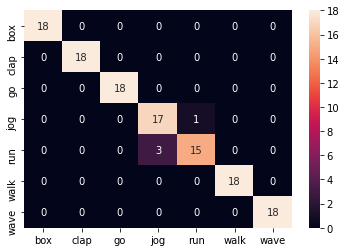

In [5]:
import seaborn as sns
import numpy as np
from mmaction.core import confusion_matrix 

gt_labels = [ann['label'] for ann in dataset.load_annotations()]
pred = np.argmax(outputs, axis=1)
cf_mat = confusion_matrix(pred, gt_labels).astype(float)

sns.heatmap(cf_mat, annot=True, xticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'], yticklabels = ['box', 'clap', 'go', 'jog', 'run', 'walk', 'wave'] )